In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.linear_model import LinearRegression 
import seaborn as sns 
seeds = 42

# 读取数据

In [3]:
fuel_df = pd.read_excel("df.xlsx", engine="openpyxl", sheet_name="fuel")
fuel_df['brand'] = fuel_df['brand'].astype('category')
# electric_df['brand'] = electric_df['brand'].fillna('传祺')

## 划分训练集和测试集

In [89]:
def spilt_dataframe(df):
    # 去掉不需要的列
#     df = df.drop(['Unnamed: 0.2','Unnamed: 0.1', 'Unnamed: 0','energy_type','title','city'],axis=1).select_dtypes(include=[np.number])
    df = df.drop(['Unnamed: 0.2','Unnamed: 0.1', 'Unnamed: 0','energy_type','title','city','standard','date_regi'],axis=1)
    df['brand'] = df['brand'].astype('category')
    
    # 划分X和y
    X_df = df[df.columns.difference(['rate_residual','price','price_new'])]
    y_df = df['rate_residual']
    # 划分训练集和测试集
    X_train,X_test,y_train,y_test = train_test_split(X_df,y_df, test_size=0.1,random_state=seeds)
    return X_train,X_test,y_train,y_test

In [90]:
fuel_X_train, fuel_X_test, fuel_y_train, fuel_y_test = spilt_dataframe(fuel_df)
print(fuel_X_train.shape)
print(fuel_X_test.shape)

(59908, 16)
(6657, 16)


In [91]:
fuel_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59908 entries, 41528 to 15795
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   brand             59908 non-null  category
 1   brand_ratio       59908 non-null  float64 
 2   color             59908 non-null  int64   
 3   displacement      59908 non-null  float64 
 4   gearbox           59908 non-null  int64   
 5   keys              59908 non-null  int64   
 6   len               59908 non-null  int64   
 7   license_location  59908 non-null  int64   
 8   mile_diff         59908 non-null  float64 
 9   mile_per_day      59908 non-null  float64 
 10  mileage           59908 non-null  float64 
 11  newness_rate      59908 non-null  float64 
 12  num_day           59908 non-null  int64   
 13  num_trans         59908 non-null  int64   
 14  predict_mileage   59908 non-null  float64 
 15  price_log         59908 non-null  float64 
dtypes: category(1), fl

## 分箱图

In [6]:
def draw_hist(data):
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=14)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    data.hist(bins=50, figsize=(12, 8))
    plt.tight_layout()

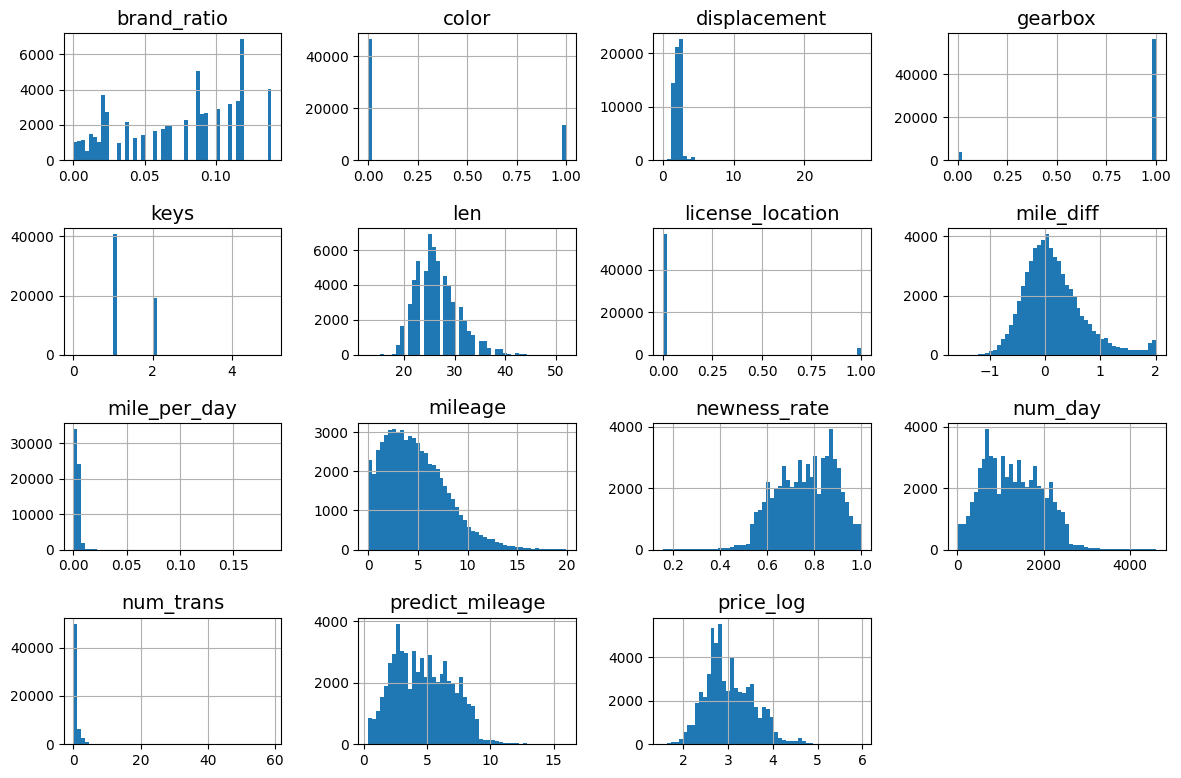

In [37]:
# 电车
draw_hist(fuel_X_train)

# lightGBM初步模型

In [115]:
# https://zhuanlan.zhihu.com/p/98684233
# 调参：https://blog.csdn.net/qq_37774098/article/details/120076102、
#    调参：https://blog.csdn.net/weixin_30916125/article/details/95253589?utm_medium=distribute.pc_relevant_t0.none-task-blog-2%7Edefault%7EBlogCommendFromMachineLearnPai2%7Edefault-1.essearch_pc_relevant&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-2%7Edefault%7EBlogCommendFromMachineLearnPai2%7Edefault-1.essearch_pc_relevant
# https://blog.csdn.net/weixin_44696221/article/details/104044951

def get_lightGBM_model(X_train, y_train, X_test,y_test):
    lgb_train_data = lgb.Dataset(X_train, y_train)
    lgb_test_data = lgb.Dataset(X_test, y_test, reference=lgb_train_data)
    # https://blog.csdn.net/weixin_43440760/article/details/108978951

    params = {
        'boosting_type': 'gbdt', 
        'objective': 'regression', 
        'metric':'rmse',
        'n_estimators':1000,
        'learning_rate': 0.01, 
        'subsample': 1, 
        'colsample_bytree': 0.7, 
        }
    #https://blog.csdn.net/weixin_43440760/article/details/108843033

    print('开始训练...')

    gbm_model = lgb.train(params,
                    lgb_train_data,
                    num_boost_round=10,
                    valid_sets = [lgb_train_data,lgb_test_data]
                         )
    
    return gbm_model
    

In [116]:
fuel_gbm_model = get_lightGBM_model(fuel_X_train,fuel_y_train,fuel_X_test,fuel_y_test)

开始训练...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1677
[LightGBM] [Info] Number of data points in the train set: 59908, number of used features: 16
[LightGBM] [Info] Start training from score 0.577755
[1]	training's rmse: 0.144545	valid_1's rmse: 0.145193
[2]	training's rmse: 0.14351	valid_1's rmse: 0.144159
[3]	training's rmse: 0.142391	valid_1's rmse: 0.143039
[4]	training's rmse: 0.141285	valid_1's rmse: 0.14193
[5]	training's rmse: 0.140286	valid_1's rmse: 0.140931
[6]	training's rmse: 0.139355	valid_1's rmse: 0.140002
[7]	training's rmse: 0.138285	valid_1's rmse: 0.138931
[8]	training's rmse: 0.137227	valid_1's rmse: 0.137873
[9]	training's rmse: 0.136182	valid_1's rmse: 0.136826
[10]	training's rmse: 0.135241	valid_1's rmse: 0.135888
[11]	training's rmse: 0.134219	valid_1's rmse: 0.134867
[12]	training's rmse: 0.133214	valid_1's r

c:\users\hp\downloads\python39\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\users\hp\downloads\python39\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\users\hp\downloads\python39\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[43]	training's rmse: 0.108139	valid_1's rmse: 0.108851
[44]	training's rmse: 0.107515	valid_1's rmse: 0.108226
[45]	training's rmse: 0.106896	valid_1's rmse: 0.107614
[46]	training's rmse: 0.10621	valid_1's rmse: 0.106925
[47]	training's rmse: 0.105538	valid_1's rmse: 0.106258
[48]	training's rmse: 0.104872	valid_1's rmse: 0.105592
[49]	training's rmse: 0.104292	valid_1's rmse: 0.105014
[50]	training's rmse: 0.103711	valid_1's rmse: 0.104436
[51]	training's rmse: 0.103073	valid_1's rmse: 0.103802
[52]	training's rmse: 0.102509	valid_1's rmse: 0.103243
[53]	training's rmse: 0.101952	valid_1's rmse: 0.102692
[54]	training's rmse: 0.101336	valid_1's rmse: 0.102078
[55]	training's rmse: 0.100723	valid_1's rmse: 0.101469
[56]	training's rmse: 0.10012	valid_1's rmse: 0.100869
[57]	training's rmse: 0.0996049	valid_1's rmse: 0.100359
[58]	training's rmse: 0.099012	valid_1's rmse: 0.0997652
[59]	training's rmse: 0.0984969	valid_1's rmse: 0.0992573
[60]	training's rmse: 0.0979185	valid_1's rmse

[259]	training's rmse: 0.0561683	valid_1's rmse: 0.0577118
[260]	training's rmse: 0.0561364	valid_1's rmse: 0.0576809
[261]	training's rmse: 0.0560611	valid_1's rmse: 0.0576134
[262]	training's rmse: 0.0559924	valid_1's rmse: 0.0575486
[263]	training's rmse: 0.0559434	valid_1's rmse: 0.0575041
[264]	training's rmse: 0.0558808	valid_1's rmse: 0.0574486
[265]	training's rmse: 0.0558203	valid_1's rmse: 0.0573938
[266]	training's rmse: 0.0557496	valid_1's rmse: 0.0573277
[267]	training's rmse: 0.0556893	valid_1's rmse: 0.0572725
[268]	training's rmse: 0.0556476	valid_1's rmse: 0.0572319
[269]	training's rmse: 0.0556077	valid_1's rmse: 0.057191
[270]	training's rmse: 0.055541	valid_1's rmse: 0.0571281
[271]	training's rmse: 0.0554719	valid_1's rmse: 0.0570638
[272]	training's rmse: 0.0554071	valid_1's rmse: 0.0570034
[273]	training's rmse: 0.0553615	valid_1's rmse: 0.056959
[274]	training's rmse: 0.0553187	valid_1's rmse: 0.0569171
[275]	training's rmse: 0.0552628	valid_1's rmse: 0.0568679


[413]	training's rmse: 0.0504325	valid_1's rmse: 0.0524208
[414]	training's rmse: 0.05042	valid_1's rmse: 0.0524101
[415]	training's rmse: 0.0504091	valid_1's rmse: 0.0524017
[416]	training's rmse: 0.0503952	valid_1's rmse: 0.0523896
[417]	training's rmse: 0.050381	valid_1's rmse: 0.0523748
[418]	training's rmse: 0.0503634	valid_1's rmse: 0.0523594
[419]	training's rmse: 0.0503317	valid_1's rmse: 0.0523261
[420]	training's rmse: 0.0503134	valid_1's rmse: 0.0523076
[421]	training's rmse: 0.0502857	valid_1's rmse: 0.0522818
[422]	training's rmse: 0.0502562	valid_1's rmse: 0.0522532
[423]	training's rmse: 0.050232	valid_1's rmse: 0.0522297
[424]	training's rmse: 0.0502141	valid_1's rmse: 0.0522133
[425]	training's rmse: 0.050185	valid_1's rmse: 0.0521866
[426]	training's rmse: 0.0501669	valid_1's rmse: 0.0521715
[427]	training's rmse: 0.0501387	valid_1's rmse: 0.0521444
[428]	training's rmse: 0.0501091	valid_1's rmse: 0.0521179
[429]	training's rmse: 0.0500938	valid_1's rmse: 0.0521048
[4

[586]	training's rmse: 0.0475156	valid_1's rmse: 0.0498834
[587]	training's rmse: 0.0475058	valid_1's rmse: 0.0498768
[588]	training's rmse: 0.0474911	valid_1's rmse: 0.0498634
[589]	training's rmse: 0.0474758	valid_1's rmse: 0.0498508
[590]	training's rmse: 0.0474561	valid_1's rmse: 0.0498321
[591]	training's rmse: 0.0474479	valid_1's rmse: 0.0498259
[592]	training's rmse: 0.047429	valid_1's rmse: 0.0498103
[593]	training's rmse: 0.0474206	valid_1's rmse: 0.0498035
[594]	training's rmse: 0.0474046	valid_1's rmse: 0.0497891
[595]	training's rmse: 0.0473967	valid_1's rmse: 0.0497836
[596]	training's rmse: 0.0473837	valid_1's rmse: 0.0497735
[597]	training's rmse: 0.0473721	valid_1's rmse: 0.0497632
[598]	training's rmse: 0.0473639	valid_1's rmse: 0.0497569
[599]	training's rmse: 0.0473557	valid_1's rmse: 0.0497513
[600]	training's rmse: 0.0473447	valid_1's rmse: 0.0497425
[601]	training's rmse: 0.0473356	valid_1's rmse: 0.0497355
[602]	training's rmse: 0.0473214	valid_1's rmse: 0.049718

[772]	training's rmse: 0.0459028	valid_1's rmse: 0.0485561
[773]	training's rmse: 0.0458987	valid_1's rmse: 0.0485531
[774]	training's rmse: 0.0458942	valid_1's rmse: 0.0485496
[775]	training's rmse: 0.0458878	valid_1's rmse: 0.0485453
[776]	training's rmse: 0.045883	valid_1's rmse: 0.0485421
[777]	training's rmse: 0.045876	valid_1's rmse: 0.0485369
[778]	training's rmse: 0.0458685	valid_1's rmse: 0.0485311
[779]	training's rmse: 0.0458632	valid_1's rmse: 0.0485266
[780]	training's rmse: 0.0458595	valid_1's rmse: 0.0485251
[781]	training's rmse: 0.0458517	valid_1's rmse: 0.048519
[782]	training's rmse: 0.0458458	valid_1's rmse: 0.0485139
[783]	training's rmse: 0.0458414	valid_1's rmse: 0.0485109
[784]	training's rmse: 0.0458345	valid_1's rmse: 0.0485055
[785]	training's rmse: 0.0458301	valid_1's rmse: 0.0485028
[786]	training's rmse: 0.045827	valid_1's rmse: 0.0485013
[787]	training's rmse: 0.0458199	valid_1's rmse: 0.0484937
[788]	training's rmse: 0.0458132	valid_1's rmse: 0.0484868
[

[979]	training's rmse: 0.0447458	valid_1's rmse: 0.047688
[980]	training's rmse: 0.0447377	valid_1's rmse: 0.0476826
[981]	training's rmse: 0.044732	valid_1's rmse: 0.0476786
[982]	training's rmse: 0.0447289	valid_1's rmse: 0.0476775
[983]	training's rmse: 0.044726	valid_1's rmse: 0.0476759
[984]	training's rmse: 0.0447216	valid_1's rmse: 0.0476729
[985]	training's rmse: 0.0447166	valid_1's rmse: 0.047669
[986]	training's rmse: 0.0447107	valid_1's rmse: 0.0476649
[987]	training's rmse: 0.0447078	valid_1's rmse: 0.0476631
[988]	training's rmse: 0.0447035	valid_1's rmse: 0.0476597
[989]	training's rmse: 0.0447001	valid_1's rmse: 0.0476578
[990]	training's rmse: 0.0446976	valid_1's rmse: 0.0476569
[991]	training's rmse: 0.0446937	valid_1's rmse: 0.0476545
[992]	training's rmse: 0.0446897	valid_1's rmse: 0.0476526
[993]	training's rmse: 0.0446831	valid_1's rmse: 0.047647
[994]	training's rmse: 0.0446787	valid_1's rmse: 0.0476439
[995]	training's rmse: 0.0446719	valid_1's rmse: 0.0476375
[9

# 评价初步模型

In [117]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

def Evaluate(y_test, y_pre):
    R2 = r2_score(y_test, y_pre)
    MAPE = np.mean(np.abs((y_pre - y_test) / y_test))
    MAE = mean_absolute_error(y_test, y_pre)
    MSE = mean_squared_error(y_test, y_pre)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pre))
    print('R2:',R2)
    print('MAPE:',MAPE)    
    print('MAE:',MAE)
    print('MSE:',MSE)
    print('RMSE:',RMSE)


In [118]:
print('油车')
Evaluate(fuel_y_test,fuel_gbm_model.predict(fuel_X_test))

油车
R2: 0.8938430086166712
MAPE: 0.06505380057465696
MAE: 0.035254631432209325
MSE: 0.0022681557100118358
RMSE: 0.04762515837256435


In [119]:
import matplotlib.pyplot as plt

def graph(real,pred):
    fig=plt.figure(figsize=(10, 5))
    #导入数据
    x = range(len(real))
    #绘图命令
    plt.plot(x, real, lw=0.1, ls='-', c='r',marker='*',label=u'y_test')
    plt.plot(x, pred, lw=0.1, ls='-', c='k',marker='*',label=u'y_pred')
#     ex = np.array(pd.Series(real)-pd.Series(pred))
    print(real)
#     print(ex)
#     plt.scatter(x, real,marker='*',label=u'y_test')
#     plt.scatter(x, pred,marker='.',label=u'y_pred')
#     plt.errorbar(x,real,yerr=ex,capsize=3,capthick=2)
#     plt.vlines(x,ymin=0,ymax=np.max(real),label='vlines',color='green',lw=0.1)
    plt.legend()
    plt.title("first prediction on test data")
    plt.xlabel("index") #X轴标签
    plt.ylabel("rate_residual")
    plt.plot()
    #show出图形
    plt.show()


In [120]:
rand_sample = np.random.randint(0,len(fuel_y_test),size=50)
fuel_y_pred = electric_gbm_model.predict(fuel_X_test)
graph(fuel_y_test.iloc[rand_sample],fuel_y_pred[rand_sample])

LightGBMError: The number of features in data (16) is not the same as it was in training data (15).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

# 预测保值率

热力图：https://blog.csdn.net/qq_42532598/article/details/120857608

参数和原理：https://blog.csdn.net/simonchen198774/article/details/124363864

# 网格搜索找最优

绘制学习率曲线与验证曲线：https://www.jianshu.com/p/2ecad8214132

参数：https://blog.csdn.net/qq_37774098/article/details/120076102

https://blog.csdn.net/xfxlesson/article/details/102511275

重要参数+grid：https://blog.csdn.net/weixin_44696221/article/details/104044951

!!!

在2017年年1月微软在GitHub的上开源了LightGBM。该算法在不降低准确率的前提下，速度提升了10倍左右，占用内存下降了3倍左右。LightGBM是个快速的，分布式的，高性能的基于决策树算法的梯度提升算法。可用于排序，分类，回归以及很多其他的机器学习任务中。其详细的原理及操作内容详见：LightGBM 中文文档。
————————————————
版权声明：本文为CSDN博主「浅笑古今」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/u012735708/article/details/83749703

https://blog.csdn.net/qq_39777550/article/details/109277937

## best n_estimators

In [ ]:
metric ：l2、quantile、poisson、gamma、tweedie

In [ ]:
https://www.jianshu.com/p/2ecad8214132

In [107]:
lgb_train_data = lgb.Dataset(fuel_X_train, fuel_y_train.values)
lgb_test_data = lgb.Dataset(fuel_X_test, fuel_y_test, reference=lgb_train_data)

In [59]:
params = {
        'boosting_type': 'gbdt', 
        'objective': 'regression', 
        'early_stop_round':100,
        'learning_rate': 0.01, 
        'subsample': 1, 
        'colsample_bytree': 0.7, 
        }

cv_results = lgb.cv(
    params, lgb_train_data, num_boost_round=1000, nfold=5, stratified=False, shuffle=True, metrics='rmse',
    early_stopping_rounds=50, verbose_eval=50, show_stdv=True, seed=0)

best_n_estimators = len(cv_results['rmse-mean'])
print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', cv_results['rmse-mean'][-1])


c:\users\hp\downloads\python39\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 47924, number of used features: 15
[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 47924, number of used features: 15
[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warni

c:\users\hp\downloads\python39\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	cv_agg's rmse: 0.107426 + 0.00112713
[100]	cv_agg's rmse: 0.0875412 + 0.00107984
[150]	cv_agg's rmse: 0.0769375 + 0.00101284
[200]	cv_agg's rmse: 0.0704525 + 0.000932464
[250]	cv_agg's rmse: 0.066192 + 0.000861467
[300]	cv_agg's rmse: 0.0629477 + 0.000850166
[350]	cv_agg's rmse: 0.0601715 + 0.000832046
[400]	cv_agg's rmse: 0.0579154 + 0.000764078
[450]	cv_agg's rmse: 0.0561367 + 0.000720617
[500]	cv_agg's rmse: 0.054581 + 0.000693191
[550]	cv_agg's rmse: 0.0534906 + 0.000677025
[600]	cv_agg's rmse: 0.0526461 + 0.000683531
[650]	cv_agg's rmse: 0.0519614 + 0.000676158
[700]	cv_agg's rmse: 0.0514234 + 0.000671112
[750]	cv_agg's rmse: 0.0509403 + 0.000647167
[800]	cv_agg's rmse: 0.0505453 + 0.000645656
[850]	cv_agg's rmse: 0.0502162 + 0.000643887
[900]	cv_agg's rmse: 0.04989 + 0.000648725
[950]	cv_agg's rmse: 0.0496225 + 0.000642238
[1000]	cv_agg's rmse: 0.0493608 + 0.000631546
best n_estimators: 1000
best cv score: 0.04936079488544206


In [ ]:
# best n_estimators: 1000
# best cv score: 0.04936079488544206

## 热力图

In [60]:
# 画热力图
def drawHeatmap(gs_obj):
    gs_params = gs_obj.cv_results_['params']
    i = 0
    for d in gs_params:
        d['score'] = gs_obj.cv_results_['mean_test_score'][i]
        i=i+1
    df= pd.DataFrame(gs_params).pivot(columns=list(gs_params[0].keys())[0],
                                                   index=list(gs_params[0].keys())[1], 
                                                   values='score')
    sns.heatmap(df, annot=True, fmt='.4f', cmap="YlGnBu")
    plt.show()

## 精确度：max_depth 和 num_leaves

In [62]:
from sklearn.model_selection import GridSearchCV
### 我们可以创建lgb的sklearn模型，使用上面选择的(学习率，评估器数目)
learn_rate=0.01
best_n_estimators=1000
model_lgb = lgb.LGBMRegressor(objective='regression',
                              learning_rate=learn_rate, 
                              n_estimators=best_n_estimators,
                              early_stop_round=100,
                              metric='rmse')
 
params_test1={
    'max_depth': range(4,8,1),
    'num_leaves':range(80, 200, 10)
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch1.fit(fuel_X_train, fuel_y_train)
max_depth = gsearch1.best_params_['max_depth']
num_leaves = gsearch1.best_params_['num_leaves']
gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Warning] Unknown parameter: early_stop_round


({'max_depth': 7, 'num_leaves': 120}, -0.002214558795771155)

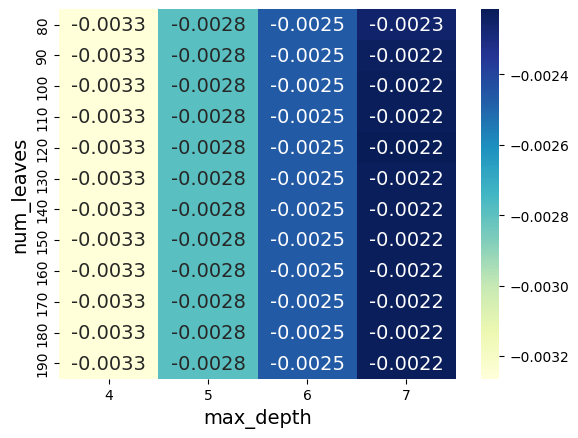

In [64]:
drawHeatmap(gsearch1)

In [66]:
model_lgb = lgb.LGBMRegressor(objective='regression',
                              learning_rate=learn_rate, 
                              n_estimators=best_n_estimators,
                              early_stop_round=100,
                              metric='rmse')
 
params_test1={
    'max_depth': range(6,10,1),
    'num_leaves': [100],
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch1.fit(fuel_X_train, fuel_y_train)
max_depth = gsearch1.best_params_['max_depth']
num_leaves = gsearch1.best_params_['num_leaves']
gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


({'max_depth': 9, 'num_leaves': 100}, -0.0020625812966194564)

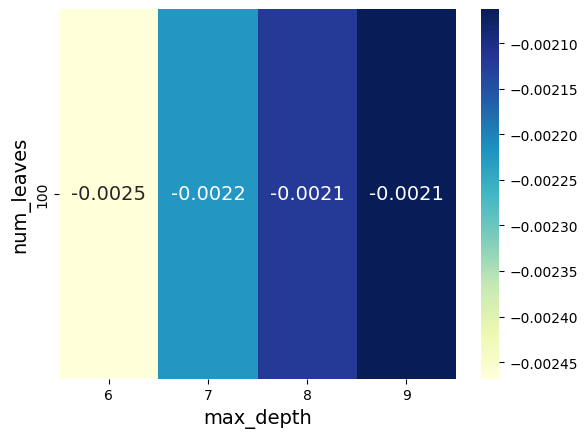

In [69]:
drawHeatmap(gsearch1)

In [95]:
# so we choose 8
max_depth = 8

## 降低过拟合：min_child_samples 和 min_child_weight

In [35]:
# https://blog.csdn.net/weixin_30916125/article/details/95253589?utm_medium=distribute.pc_relevant_t0.none-task-blog-2%7Edefault%7EBlogCommendFromMachineLearnPai2%7Edefault-1.essearch_pc_relevant&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-2%7Edefault%7EBlogCommendFromMachineLearnPai2%7Edefault-1.essearch_pc_relevant

In [96]:
params_test2={
    'min_child_samples': range(19,24),
    'min_child_weight':[0.001, 0.002,0.01,0.02]
}
model_lgb = lgb.LGBMRegressor(objective='regression',
                              learning_rate=learn_rate, 
                              n_estimators=best_n_estimators,
                              max_depth=max_depth,
                              num_leaves=num_leaves,
                              metric='rmse')

gsearch2 = GridSearchCV(estimator=model_lgb, 
                        param_grid=params_test2, 
                        scoring='neg_mean_squared_error', 
                        cv=5, 
                        verbose=1, 
                        n_jobs=4)
gsearch2.fit(fuel_X_train, fuel_y_train)
min_child_samples = gsearch2.best_params_['min_child_samples']
min_child_weight = gsearch2.best_params_['min_child_weight']
gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


({'min_child_samples': 19, 'min_child_weight': 0.001}, -0.0019211525164653347)

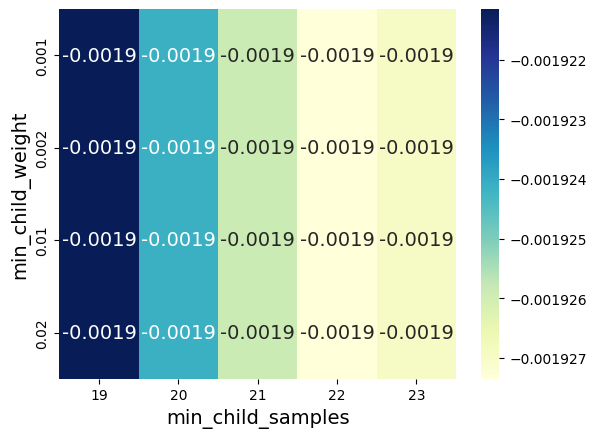

In [97]:
drawHeatmap(gsearch2)

In [98]:
min_child_samples=23

## 降低过拟合feature_fraction 和 bagging_fraction

In [99]:
params_test3={
    'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9],
    'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0]
}
print('min_child_weight')
model_lgb = lgb.LGBMRegressor(objective='regression',
                              learning_rate=learn_rate, 
                              n_estimators=best_n_estimators,
                              max_depth=max_depth,
                              num_leaves=num_leaves,
                              min_child_samples=min_child_samples,
                              min_child_weight=min_child_weight,
                              metric='rmse')

gsearch3 = GridSearchCV(estimator=model_lgb, param_grid=params_test3, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch3.fit(fuel_X_train, fuel_y_train)
bagging_fraction = gsearch3.best_params_['bagging_fraction']
feature_fraction = gsearch3.best_params_['feature_fraction']
gsearch3.best_params_, gsearch3.best_score_

min_child_weight
Fitting 5 folds for each of 25 candidates, totalling 125 fits


({'bagging_fraction': 0.6, 'feature_fraction': 0.6}, -0.0019051740282123146)

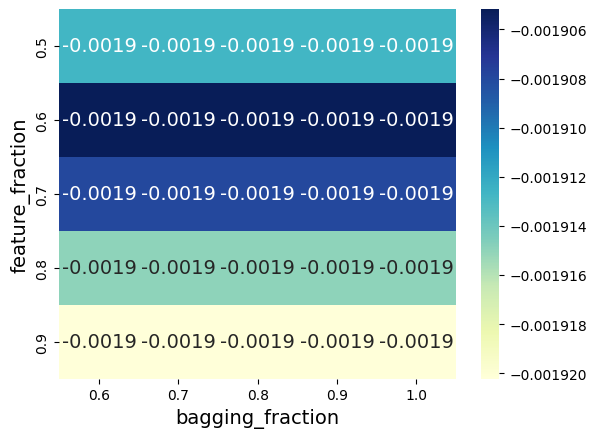

In [100]:
drawHeatmap(gsearch3)

## 正则化参数

## 降低learning_rate

使用较高的学习速率是因为可以让收敛更快，但是准确度肯定没有d低学习率好。
最后，我们使用较低的学习速率，以期望进一步的优化分数。

In [101]:
params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression', 
 
    'learning_rate': 0.005, 
    'num_leaves': num_leaves, 
    'max_depth': max_depth,
    'min_child_samples':min_child_samples,
    'min_child_weight':min_child_weight,
    'feature_fraction':feature_fraction,
    'bagging_fraction':bagging_fraction
    }

cv_results = lgb.cv(
    params, lgb_train_data, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='rmse',
    early_stopping_rounds=50, verbose_eval=100, show_stdv=True)
best_n_estimators = len(cv_results['rmse-mean'])
print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', cv_results['rmse-mean'][-1])

c:\users\hp\downloads\python39\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\hp\downloads\python39\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 47924, number of used features: 15
[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 47924, number of used features: 15
[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warning] Unknown parameter: early_stop_round
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the ov

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1600]	cv_agg's rmse: 0.0466722 + 0.000539726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2800]	cv_agg's rmse: 0.0444063 + 0.0005639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4200]	cv_agg's rmse: 0.0429379 + 0.000558765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4700]	cv_agg's rmse: 0.0425486 + 0.000558404
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4900]	cv_agg's rmse: 0.0424222 + 0.000549611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5700]	cv_agg's rmse: 0.0419478 + 0.00052706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5900]	cv_agg's rmse: 0.041851 + 0.000526596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7500]	cv_agg's rmse: 0.0411715 + 0.000492207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8500]	cv_agg's rmse: 0.0408839 + 0.000466581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8700]	cv_agg's rmse: 0.0408322 + 0.000460325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9800]	cv_agg's rmse: 0.0405453 + 0.00045394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

best n_estimators: 10000
best cv score: 0.040503927421031496


## 重写模型

In [108]:
params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression', 
    'n_estimators':best_n_estimators,
    'learning_rate': 0.005, 
    'num_leaves': num_leaves, 
    'max_depth': max_depth,
    'min_child_samples':min_child_samples,
    'min_child_weight':min_child_weight,
    'feature_fraction':feature_fraction,
    'bagging_fraction':bagging_fraction,
    'metric': 'rmse'
    }
    #https://blog.csdn.net/weixin_43440760/article/details/108843033

print('开始训练...')
evals_result = {}  # 记录训练结果所用
best_gbm_model = lgb.train(params,
                    lgb_train_data,
                    num_boost_round=10000,
                    evals_result=evals_result,
                    valid_sets = [lgb_train_data,lgb_test_data]
                         )

开始训练...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1677
[LightGBM] [Info] Number of data points in the train set: 59908, number of used features: 16
[LightGBM] [Info] Start training from score 0.577755
[1]	training's rmse: 0.145017	valid_1's rmse: 0.145669
[2]	training's rmse: 0.144459	valid_1's rmse: 0.145114
[3]	training's rmse: 0.143861	valid_1's rmse: 0.144518
[4]	training's rmse: 0.143266	valid_1's rmse: 0.143923
[5]	training's rmse: 0.142757	valid_1's rmse: 0.143413
[6]	training's rmse: 0.142268	valid_1's rmse: 0.142926
[7]	training's rmse: 0.141682	valid_1's rmse: 0.142339
[8]	training's rmse: 0.141155	valid_1's rmse: 0.141817
[9]	training's rmse: 0.140573	valid_1's rmse: 0.141235
[10]	training's rmse: 0.140041	valid_1's rmse: 0.140707
[11]	training's rmse: 0.139468	valid_1's rmse: 0.140134
[12]	training's rmse: 0.138901	valid_1's

c:\users\hp\downloads\python39\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\users\hp\downloads\python39\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\hp\downloads\python39\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\users\hp\downloads\python39\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[32]	training's rmse: 0.128634	valid_1's rmse: 0.129348
[33]	training's rmse: 0.128126	valid_1's rmse: 0.128841
[34]	training's rmse: 0.127662	valid_1's rmse: 0.128379
[35]	training's rmse: 0.127175	valid_1's rmse: 0.127893
[36]	training's rmse: 0.126688	valid_1's rmse: 0.127408
[37]	training's rmse: 0.126207	valid_1's rmse: 0.12693
[38]	training's rmse: 0.125725	valid_1's rmse: 0.12645
[39]	training's rmse: 0.125234	valid_1's rmse: 0.125963
[40]	training's rmse: 0.124781	valid_1's rmse: 0.125513
[41]	training's rmse: 0.12433	valid_1's rmse: 0.125066
[42]	training's rmse: 0.123845	valid_1's rmse: 0.124585
[43]	training's rmse: 0.123559	valid_1's rmse: 0.124306
[44]	training's rmse: 0.123122	valid_1's rmse: 0.123871
[45]	training's rmse: 0.122681	valid_1's rmse: 0.123435
[46]	training's rmse: 0.122204	valid_1's rmse: 0.122962
[47]	training's rmse: 0.121747	valid_1's rmse: 0.122505
[48]	training's rmse: 0.121276	valid_1's rmse: 0.122037
[49]	training's rmse: 0.120853	valid_1's rmse: 0.12

[195]	training's rmse: 0.0775569	valid_1's rmse: 0.0787452
[196]	training's rmse: 0.077352	valid_1's rmse: 0.0785434
[197]	training's rmse: 0.0771482	valid_1's rmse: 0.0783412
[198]	training's rmse: 0.0769744	valid_1's rmse: 0.0781711
[199]	training's rmse: 0.0768019	valid_1's rmse: 0.0780037
[200]	training's rmse: 0.0766063	valid_1's rmse: 0.0778103
[201]	training's rmse: 0.0764624	valid_1's rmse: 0.0776718
[202]	training's rmse: 0.0762943	valid_1's rmse: 0.0775091
[203]	training's rmse: 0.076134	valid_1's rmse: 0.0773534
[204]	training's rmse: 0.0759666	valid_1's rmse: 0.0771901
[205]	training's rmse: 0.0758034	valid_1's rmse: 0.077031
[206]	training's rmse: 0.0756089	valid_1's rmse: 0.0768389
[207]	training's rmse: 0.0754306	valid_1's rmse: 0.0766629
[208]	training's rmse: 0.0752698	valid_1's rmse: 0.076508
[209]	training's rmse: 0.0750823	valid_1's rmse: 0.0763244
[210]	training's rmse: 0.0749252	valid_1's rmse: 0.0761726
[211]	training's rmse: 0.0747521	valid_1's rmse: 0.0760038
[

[337]	training's rmse: 0.0598163	valid_1's rmse: 0.0615731
[338]	training's rmse: 0.0597597	valid_1's rmse: 0.0615204
[339]	training's rmse: 0.0596908	valid_1's rmse: 0.0614554
[340]	training's rmse: 0.0596185	valid_1's rmse: 0.0613879
[341]	training's rmse: 0.0595357	valid_1's rmse: 0.0613066
[342]	training's rmse: 0.0594459	valid_1's rmse: 0.0612208
[343]	training's rmse: 0.0593609	valid_1's rmse: 0.061139
[344]	training's rmse: 0.0592702	valid_1's rmse: 0.0610526
[345]	training's rmse: 0.0591849	valid_1's rmse: 0.0609706
[346]	training's rmse: 0.0591188	valid_1's rmse: 0.0609098
[347]	training's rmse: 0.0590476	valid_1's rmse: 0.0608411
[348]	training's rmse: 0.0589946	valid_1's rmse: 0.0607912
[349]	training's rmse: 0.058911	valid_1's rmse: 0.0607104
[350]	training's rmse: 0.0588251	valid_1's rmse: 0.0606281
[351]	training's rmse: 0.0587432	valid_1's rmse: 0.0605513
[352]	training's rmse: 0.0586739	valid_1's rmse: 0.0604841
[353]	training's rmse: 0.0586121	valid_1's rmse: 0.0604258

[484]	training's rmse: 0.0520314	valid_1's rmse: 0.0543121
[485]	training's rmse: 0.0519994	valid_1's rmse: 0.0542853
[486]	training's rmse: 0.0519644	valid_1's rmse: 0.0542541
[487]	training's rmse: 0.0519338	valid_1's rmse: 0.0542287
[488]	training's rmse: 0.0519024	valid_1's rmse: 0.0542018
[489]	training's rmse: 0.0518732	valid_1's rmse: 0.0541776
[490]	training's rmse: 0.0518305	valid_1's rmse: 0.0541382
[491]	training's rmse: 0.0518029	valid_1's rmse: 0.0541138
[492]	training's rmse: 0.0517615	valid_1's rmse: 0.054075
[493]	training's rmse: 0.0517213	valid_1's rmse: 0.0540392
[494]	training's rmse: 0.0516778	valid_1's rmse: 0.0540005
[495]	training's rmse: 0.0516562	valid_1's rmse: 0.0539811
[496]	training's rmse: 0.0516298	valid_1's rmse: 0.0539564
[497]	training's rmse: 0.051608	valid_1's rmse: 0.053937
[498]	training's rmse: 0.0515876	valid_1's rmse: 0.0539189
[499]	training's rmse: 0.0515623	valid_1's rmse: 0.053897
[500]	training's rmse: 0.0515337	valid_1's rmse: 0.0538729
[

[624]	training's rmse: 0.048435	valid_1's rmse: 0.0511227
[625]	training's rmse: 0.0484182	valid_1's rmse: 0.051108
[626]	training's rmse: 0.0484078	valid_1's rmse: 0.0510997
[627]	training's rmse: 0.0483888	valid_1's rmse: 0.0510829
[628]	training's rmse: 0.0483731	valid_1's rmse: 0.0510701
[629]	training's rmse: 0.0483536	valid_1's rmse: 0.0510533
[630]	training's rmse: 0.0483434	valid_1's rmse: 0.0510459
[631]	training's rmse: 0.0483248	valid_1's rmse: 0.0510296
[632]	training's rmse: 0.0483093	valid_1's rmse: 0.0510166
[633]	training's rmse: 0.0482991	valid_1's rmse: 0.0510083
[634]	training's rmse: 0.048284	valid_1's rmse: 0.0509956
[635]	training's rmse: 0.0482688	valid_1's rmse: 0.0509846
[636]	training's rmse: 0.0482502	valid_1's rmse: 0.0509677
[637]	training's rmse: 0.0482262	valid_1's rmse: 0.0509463
[638]	training's rmse: 0.0482034	valid_1's rmse: 0.0509261
[639]	training's rmse: 0.0481803	valid_1's rmse: 0.0509055
[640]	training's rmse: 0.0481565	valid_1's rmse: 0.0508839


[777]	training's rmse: 0.0461891	valid_1's rmse: 0.0492056
[778]	training's rmse: 0.04618	valid_1's rmse: 0.0491975
[779]	training's rmse: 0.0461705	valid_1's rmse: 0.0491893
[780]	training's rmse: 0.0461612	valid_1's rmse: 0.0491817
[781]	training's rmse: 0.0461459	valid_1's rmse: 0.049168
[782]	training's rmse: 0.0461287	valid_1's rmse: 0.0491519
[783]	training's rmse: 0.0461187	valid_1's rmse: 0.0491436
[784]	training's rmse: 0.0461089	valid_1's rmse: 0.0491359
[785]	training's rmse: 0.0461034	valid_1's rmse: 0.049133
[786]	training's rmse: 0.0460978	valid_1's rmse: 0.0491291
[787]	training's rmse: 0.0460837	valid_1's rmse: 0.0491154
[788]	training's rmse: 0.0460703	valid_1's rmse: 0.0491044
[789]	training's rmse: 0.0460592	valid_1's rmse: 0.0490963
[790]	training's rmse: 0.0460503	valid_1's rmse: 0.0490879
[791]	training's rmse: 0.0460404	valid_1's rmse: 0.0490801
[792]	training's rmse: 0.0460334	valid_1's rmse: 0.0490747
[793]	training's rmse: 0.0460244	valid_1's rmse: 0.0490668
[

[939]	training's rmse: 0.0446732	valid_1's rmse: 0.0479484
[940]	training's rmse: 0.0446635	valid_1's rmse: 0.0479416
[941]	training's rmse: 0.0446552	valid_1's rmse: 0.0479351
[942]	training's rmse: 0.0446501	valid_1's rmse: 0.0479309
[943]	training's rmse: 0.0446427	valid_1's rmse: 0.0479268
[944]	training's rmse: 0.0446345	valid_1's rmse: 0.0479202
[945]	training's rmse: 0.044627	valid_1's rmse: 0.047915
[946]	training's rmse: 0.0446193	valid_1's rmse: 0.0479087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[947]	training's rmse: 0.0446163	valid_1's rmse: 0.0479064
[948]	training's rmse: 0.0446091	valid_1's rmse: 0.0478996
[949]	training's rmse: 0.0446032	valid_1's rmse: 0.0478947
[950]	training's rmse: 0.0445953	valid_1's rmse: 0.0478897
[951]	training's rmse: 0.0445902	valid_1's rmse: 0.0478859
[952]	training's rmse: 0.0445776	valid_1's rmse: 0.0478748
[953]	training's rmse: 0.0445649	valid_1's rmse: 0.0478638
[954]	training's rmse: 0.0445576	valid_1's

[1096]	training's rmse: 0.0435085	valid_1's rmse: 0.0470099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1097]	training's rmse: 0.0435053	valid_1's rmse: 0.0470078
[1098]	training's rmse: 0.0434972	valid_1's rmse: 0.0470005
[1099]	training's rmse: 0.0434896	valid_1's rmse: 0.0469944
[1100]	training's rmse: 0.0434831	valid_1's rmse: 0.0469884
[1101]	training's rmse: 0.0434777	valid_1's rmse: 0.0469843
[1102]	training's rmse: 0.0434699	valid_1's rmse: 0.0469778
[1103]	training's rmse: 0.0434614	valid_1's rmse: 0.0469699
[1104]	training's rmse: 0.0434583	valid_1's rmse: 0.0469682
[1105]	training's rmse: 0.043453	valid_1's rmse: 0.0469651
[1106]	training's rmse: 0.0434477	valid_1's rmse: 0.0469607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1107]	training's rmse: 0.043444	valid_1's rmse: 0.0469582
[1108]	training's rmse: 0.0434356	valid_1's rmse: 0.0469504
[1109]	training's rmse: 0.0434268	valid_1's rmse: 0.0469423
[1110]	train

[1232]	training's rmse: 0.0427472	valid_1's rmse: 0.0463998
[1233]	training's rmse: 0.0427446	valid_1's rmse: 0.0463986
[1234]	training's rmse: 0.0427389	valid_1's rmse: 0.0463925
[1235]	training's rmse: 0.0427357	valid_1's rmse: 0.0463904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1236]	training's rmse: 0.0427323	valid_1's rmse: 0.0463876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1237]	training's rmse: 0.0427291	valid_1's rmse: 0.0463853
[1238]	training's rmse: 0.042724	valid_1's rmse: 0.0463801
[1239]	training's rmse: 0.0427201	valid_1's rmse: 0.0463783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1240]	training's rmse: 0.0427165	valid_1's rmse: 0.0463766
[1241]	training's rmse: 0.0427099	valid_1's rmse: 0.0463708
[1242]	training's rmse: 0.042706	valid_1's rmse: 0.0463685
[1243]	training's rmse: 0.0427006	valid_1's rmse: 0.0463656
[1244]	training's rmse: 0.0426913	valid_1's rmse: 0.04635

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1367]	training's rmse: 0.0421408	valid_1's rmse: 0.0459175
[1368]	training's rmse: 0.0421384	valid_1's rmse: 0.0459161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1369]	training's rmse: 0.0421316	valid_1's rmse: 0.0459111
[1370]	training's rmse: 0.0421263	valid_1's rmse: 0.045907
[1371]	training's rmse: 0.0421231	valid_1's rmse: 0.0459057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1372]	training's rmse: 0.0421208	valid_1's rmse: 0.0459043
[1373]	training's rmse: 0.0421145	valid_1's rmse: 0.0458999
[1374]	training's rmse: 0.0421105	valid_1's rmse: 0.045897
[1375]	training's rmse: 0.0421072	valid_1's rmse: 0.0458958
[1376]	training's rmse: 0.0421048	valid_1's rmse: 0.0458948
[1377]	training's rmse: 0.0420982	valid_1's rmse: 0.0458892
[1378]	training's rmse: 0.0420949	valid_1's rmse: 0.0458869
[1379]	training's rmse: 0.042091	valid_1's rmse: 0.045884

[1502]	training's rmse: 0.0416258	valid_1's rmse: 0.0455431
[1503]	training's rmse: 0.0416228	valid_1's rmse: 0.0455412
[1504]	training's rmse: 0.0416199	valid_1's rmse: 0.0455401
[1505]	training's rmse: 0.0416141	valid_1's rmse: 0.0455352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1506]	training's rmse: 0.0416123	valid_1's rmse: 0.0455341
[1507]	training's rmse: 0.0416062	valid_1's rmse: 0.0455287
[1508]	training's rmse: 0.0416006	valid_1's rmse: 0.0455243
[1509]	training's rmse: 0.0415964	valid_1's rmse: 0.0455217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1510]	training's rmse: 0.0415937	valid_1's rmse: 0.0455196
[1511]	training's rmse: 0.0415893	valid_1's rmse: 0.0455161
[1512]	training's rmse: 0.0415862	valid_1's rmse: 0.0455142
[1513]	training's rmse: 0.0415806	valid_1's rmse: 0.0455094
[1514]	training's rmse: 0.0415777	valid_1's rmse: 0.0455076
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1649]	training's rmse: 0.0411515	valid_1's rmse: 0.0452118
[1650]	training's rmse: 0.0411469	valid_1's rmse: 0.0452076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1651]	training's rmse: 0.0411452	valid_1's rmse: 0.0452069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1652]	training's rmse: 0.041144	valid_1's rmse: 0.045206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1653]	training's rmse: 0.0411419	valid_1's rmse: 0.0452047
[1654]	training's rmse: 0.0411394	valid_1's rmse: 0.0452035
[1655]	training's rmse: 0.0411331	valid_1's rmse: 0.0451988
[1656]	training's rmse: 0.0411283	valid_1's rmse: 0.0451952
[1657]	training's rmse: 0.0411223	valid_1's rmse: 0.0451907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1658]	training's rmse: 0.0411217	valid_1's rmse: 0.0451904
[1659]	training's rmse: 0.0

[1792]	training's rmse: 0.0407183	valid_1's rmse: 0.0449239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1793]	training's rmse: 0.0407167	valid_1's rmse: 0.0449228
[1794]	training's rmse: 0.0407141	valid_1's rmse: 0.0449211
[1795]	training's rmse: 0.0407111	valid_1's rmse: 0.0449197
[1796]	training's rmse: 0.0407058	valid_1's rmse: 0.0449155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1797]	training's rmse: 0.0407028	valid_1's rmse: 0.044914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1798]	training's rmse: 0.0407008	valid_1's rmse: 0.0449134
[1799]	training's rmse: 0.040698	valid_1's rmse: 0.0449119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1800]	training's rmse: 0.0406964	valid_1's rmse: 0.0449115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1801]	training's rmse: 0.0406941	valid_1's rmse: 0.0449099
[LightGBM] [Warning] No fur

[1944]	training's rmse: 0.0403263	valid_1's rmse: 0.0446731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1945]	training's rmse: 0.0403251	valid_1's rmse: 0.0446727
[1946]	training's rmse: 0.0403222	valid_1's rmse: 0.0446718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1947]	training's rmse: 0.04032	valid_1's rmse: 0.0446709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1948]	training's rmse: 0.0403169	valid_1's rmse: 0.044668
[1949]	training's rmse: 0.0403148	valid_1's rmse: 0.0446672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1950]	training's rmse: 0.0403138	valid_1's rmse: 0.0446667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1951]	training's rmse: 0.0403133	valid_1's rmse: 0.0446665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1952]	training's rmse: 0.0403125	valid_1's rmse: 0.0446657
[LightGBM] [W

[2081]	training's rmse: 0.0400368	valid_1's rmse: 0.0444925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2082]	training's rmse: 0.0400347	valid_1's rmse: 0.0444908
[2083]	training's rmse: 0.0400298	valid_1's rmse: 0.0444875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2084]	training's rmse: 0.0400285	valid_1's rmse: 0.0444868
[2085]	training's rmse: 0.0400259	valid_1's rmse: 0.0444856
[2086]	training's rmse: 0.0400219	valid_1's rmse: 0.0444829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2087]	training's rmse: 0.0400205	valid_1's rmse: 0.0444822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2088]	training's rmse: 0.0400202	valid_1's rmse: 0.044482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2089]	training's rmse: 0.0400189	valid_1's rmse: 0.0444814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2090]	trai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2158]	training's rmse: 0.0398733	valid_1's rmse: 0.0443951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2159]	training's rmse: 0.0398721	valid_1's rmse: 0.0443941
[2160]	training's rmse: 0.0398697	valid_1's rmse: 0.0443925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2161]	training's rmse: 0.039869	valid_1's rmse: 0.0443921
[2162]	training's rmse: 0.0398648	valid_1's rmse: 0.0443893
[2163]	training's rmse: 0.0398609	valid_1's rmse: 0.0443867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2164]	training's rmse: 0.0398592	valid_1's rmse: 0.0443862
[2165]	training's rmse: 0.0398548	valid_1's rmse: 0.0443836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2166]	training's rmse: 0.0398541	valid_1's rmse: 0.044383
[2167]	training's rmse: 0.0398516	valid_1's rmse: 0.0443822
[LightGBM] [Warning] No fur

[2240]	training's rmse: 0.0396663	valid_1's rmse: 0.0442622
[2241]	training's rmse: 0.0396644	valid_1's rmse: 0.0442616
[2242]	training's rmse: 0.0396608	valid_1's rmse: 0.0442597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2243]	training's rmse: 0.0396572	valid_1's rmse: 0.0442569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2244]	training's rmse: 0.0396553	valid_1's rmse: 0.0442559
[2245]	training's rmse: 0.0396515	valid_1's rmse: 0.0442539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2246]	training's rmse: 0.0396497	valid_1's rmse: 0.044253
[2247]	training's rmse: 0.0396441	valid_1's rmse: 0.0442483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2248]	training's rmse: 0.0396424	valid_1's rmse: 0.0442476
[2249]	training's rmse: 0.0396404	valid_1's rmse: 0.044247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2250]	training's rmse: 0.0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2365]	training's rmse: 0.0393765	valid_1's rmse: 0.0440847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2366]	training's rmse: 0.0393752	valid_1's rmse: 0.0440844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2367]	training's rmse: 0.0393715	valid_1's rmse: 0.044082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2368]	training's rmse: 0.0393691	valid_1's rmse: 0.0440802
[2369]	training's rmse: 0.0393653	valid_1's rmse: 0.0440775
[2370]	training's rmse: 0.0393619	valid_1's rmse: 0.0440749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2371]	training's rmse: 0.0393599	valid_1's rmse: 0.0440738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2372]	training's rmse: 0.0393576	valid_1's rmse: 0.0440716
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[2504]	training's rmse: 0.0391045	valid_1's rmse: 0.0439181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2505]	training's rmse: 0.0391036	valid_1's rmse: 0.0439178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2506]	training's rmse: 0.0391033	valid_1's rmse: 0.0439176
[2507]	training's rmse: 0.0391013	valid_1's rmse: 0.0439163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2508]	training's rmse: 0.0390983	valid_1's rmse: 0.043914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2509]	training's rmse: 0.0390975	valid_1's rmse: 0.0439136
[2510]	training's rmse: 0.0390939	valid_1's rmse: 0.0439114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2511]	training's rmse: 0.0390916	valid_1's rmse: 0.0439099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2512]	training's rmse: 0.0390907	valid_1's rmse: 0.0439092
[2513]	trai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2580]	training's rmse: 0.0389673	valid_1's rmse: 0.0438288
[2581]	training's rmse: 0.0389631	valid_1's rmse: 0.0438257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2582]	training's rmse: 0.038961	valid_1's rmse: 0.0438247
[2583]	training's rmse: 0.038959	valid_1's rmse: 0.0438243
[2584]	training's rmse: 0.0389574	valid_1's rmse: 0.0438237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2585]	training's rmse: 0.0389571	valid_1's rmse: 0.0438233
[2586]	training's rmse: 0.0389545	valid_1's rmse: 0.0438216
[2587]	training's rmse: 0.0389522	valid_1's rmse: 0.0438204
[2588]	training's rmse: 0.0389495	valid_1's rmse: 0.0438189
[2589]	training's rmse: 0.038946	valid_1's rmse: 0.0438164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2590]	training's rmse: 0.0389453	valid_1's rmse: 0.0438162
[LightGBM] [Warning] No further splits with

[2727]	training's rmse: 0.038711	valid_1's rmse: 0.0436755
[2728]	training's rmse: 0.0387084	valid_1's rmse: 0.0436739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2729]	training's rmse: 0.0387067	valid_1's rmse: 0.0436729
[2730]	training's rmse: 0.038704	valid_1's rmse: 0.0436718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2731]	training's rmse: 0.0387032	valid_1's rmse: 0.0436716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2732]	training's rmse: 0.0387014	valid_1's rmse: 0.0436707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2733]	training's rmse: 0.0387001	valid_1's rmse: 0.0436702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2734]	training's rmse: 0.0386998	valid_1's rmse: 0.04367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2735]	training's rmse: 0.0386988	valid_1's rmse: 0.0436691
[2736]	trainin

[2800]	training's rmse: 0.0385855	valid_1's rmse: 0.0435956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2801]	training's rmse: 0.0385845	valid_1's rmse: 0.0435952
[2802]	training's rmse: 0.038583	valid_1's rmse: 0.0435949
[2803]	training's rmse: 0.0385806	valid_1's rmse: 0.0435941
[2804]	training's rmse: 0.0385786	valid_1's rmse: 0.0435929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2805]	training's rmse: 0.038577	valid_1's rmse: 0.0435919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2806]	training's rmse: 0.0385761	valid_1's rmse: 0.0435914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2807]	training's rmse: 0.0385749	valid_1's rmse: 0.0435902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2808]	training's rmse: 0.0385733	valid_1's rmse: 0.0435889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2809]	train

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2951]	training's rmse: 0.0382924	valid_1's rmse: 0.0434187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2952]	training's rmse: 0.038292	valid_1's rmse: 0.0434181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2953]	training's rmse: 0.0382917	valid_1's rmse: 0.0434176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2954]	training's rmse: 0.0382909	valid_1's rmse: 0.0434171
[2955]	training's rmse: 0.0382872	valid_1's rmse: 0.0434139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2956]	training's rmse: 0.0382849	valid_1's rmse: 0.0434128
[2957]	training's rmse: 0.0382827	valid_1's rmse: 0.0434117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2958]	training's rmse: 0.0382812	valid_1's rmse: 0.0434115
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[3029]	training's rmse: 0.0381494	valid_1's rmse: 0.0433334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3030]	training's rmse: 0.038147	valid_1's rmse: 0.0433325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3031]	training's rmse: 0.0381463	valid_1's rmse: 0.0433317
[3032]	training's rmse: 0.0381448	valid_1's rmse: 0.0433314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3033]	training's rmse: 0.0381433	valid_1's rmse: 0.0433306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3034]	training's rmse: 0.0381427	valid_1's rmse: 0.0433302
[3035]	training's rmse: 0.038141	valid_1's rmse: 0.0433289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3036]	training's rmse: 0.0381396	valid_1's rmse: 0.0433282
[3037]	training's rmse: 0.0381355	valid_1's rmse: 0.043325
[3038]	training's rmse: 0.0381315	valid_1's rmse: 0.0433223
[LightGBM] [Warning] No furt

[3186]	training's rmse: 0.0378436	valid_1's rmse: 0.043143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3187]	training's rmse: 0.0378427	valid_1's rmse: 0.0431425
[3188]	training's rmse: 0.0378408	valid_1's rmse: 0.0431418
[3189]	training's rmse: 0.0378389	valid_1's rmse: 0.043141
[3190]	training's rmse: 0.0378342	valid_1's rmse: 0.0431373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3191]	training's rmse: 0.0378338	valid_1's rmse: 0.043137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3192]	training's rmse: 0.0378327	valid_1's rmse: 0.0431364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3193]	training's rmse: 0.0378314	valid_1's rmse: 0.0431353
[3194]	training's rmse: 0.0378268	valid_1's rmse: 0.0431315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3195]	training's rmse: 0.0378253	valid_1's rmse: 0.0431306
[LightGBM] [Warning] No furt

[3337]	training's rmse: 0.0375446	valid_1's rmse: 0.0429557
[3338]	training's rmse: 0.0375417	valid_1's rmse: 0.0429537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3339]	training's rmse: 0.0375408	valid_1's rmse: 0.0429536
[3340]	training's rmse: 0.0375388	valid_1's rmse: 0.0429526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3341]	training's rmse: 0.0375386	valid_1's rmse: 0.0429525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3342]	training's rmse: 0.0375366	valid_1's rmse: 0.0429513
[3343]	training's rmse: 0.0375348	valid_1's rmse: 0.0429508
[3344]	training's rmse: 0.037533	valid_1's rmse: 0.0429498
[3345]	training's rmse: 0.0375309	valid_1's rmse: 0.0429488
[3346]	training's rmse: 0.037529	valid_1's rmse: 0.0429477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3347]	training's rmse: 0.0375279	valid_1's rmse: 0.0429472
[3348]	training's rmse: 0.0375253	valid_1'

[3485]	training's rmse: 0.0372933	valid_1's rmse: 0.0428104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3486]	training's rmse: 0.0372931	valid_1's rmse: 0.0428103
[3487]	training's rmse: 0.0372912	valid_1's rmse: 0.042809
[3488]	training's rmse: 0.037289	valid_1's rmse: 0.0428074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3489]	training's rmse: 0.037288	valid_1's rmse: 0.042807
[3490]	training's rmse: 0.0372853	valid_1's rmse: 0.042805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3491]	training's rmse: 0.0372843	valid_1's rmse: 0.0428047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3492]	training's rmse: 0.0372835	valid_1's rmse: 0.0428039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3493]	training's rmse: 0.037281	valid_1's rmse: 0.042802
[3494]	training's rmse: 0.0372782	valid_1's rmse: 0.0428004
[LightGBM] [Warning] No further 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3632]	training's rmse: 0.037044	valid_1's rmse: 0.0426603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3633]	training's rmse: 0.0370437	valid_1's rmse: 0.0426602
[3634]	training's rmse: 0.03704	valid_1's rmse: 0.0426574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3635]	training's rmse: 0.0370385	valid_1's rmse: 0.0426567
[3636]	training's rmse: 0.0370354	valid_1's rmse: 0.0426535
[3637]	training's rmse: 0.0370337	valid_1's rmse: 0.042653
[3638]	training's rmse: 0.0370318	valid_1's rmse: 0.0426519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3639]	training's rmse: 0.0370313	valid_1's rmse: 0.0426517
[3640]	training's rmse: 0.0370289	valid_1's rmse: 0.0426498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3641]	training's rmse: 0.0370285	valid_1's rmse: 0.0426497
[LightGBM] [Warning] No furth

[3712]	training's rmse: 0.0369324	valid_1's rmse: 0.0425881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3713]	training's rmse: 0.0369304	valid_1's rmse: 0.0425865
[3714]	training's rmse: 0.0369288	valid_1's rmse: 0.042586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3715]	training's rmse: 0.0369276	valid_1's rmse: 0.0425853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3716]	training's rmse: 0.0369265	valid_1's rmse: 0.0425848
[3717]	training's rmse: 0.0369246	valid_1's rmse: 0.0425839
[3718]	training's rmse: 0.0369224	valid_1's rmse: 0.0425827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3719]	training's rmse: 0.0369216	valid_1's rmse: 0.042582
[3720]	training's rmse: 0.0369191	valid_1's rmse: 0.0425803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3721]	training's rmse: 0.0369178	valid_1's rmse: 0.0425797
[3722]	training's rmse: 0.0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3843]	training's rmse: 0.0367166	valid_1's rmse: 0.0424584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3844]	training's rmse: 0.0367157	valid_1's rmse: 0.042458
[3845]	training's rmse: 0.0367142	valid_1's rmse: 0.0424572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3846]	training's rmse: 0.0367139	valid_1's rmse: 0.0424571
[3847]	training's rmse: 0.0367108	valid_1's rmse: 0.0424547
[3848]	training's rmse: 0.0367089	valid_1's rmse: 0.0424542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3849]	training's rmse: 0.0367078	valid_1's rmse: 0.042453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3850]	training's rmse: 0.0367067	valid_1's rmse: 0.0424524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3851]	training's rmse: 0.0367064	valid_1's rmse: 0.0424522
[LightGBM] [

[3998]	training's rmse: 0.0364708	valid_1's rmse: 0.0423099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3999]	training's rmse: 0.0364697	valid_1's rmse: 0.0423094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4000]	training's rmse: 0.0364694	valid_1's rmse: 0.0423094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4001]	training's rmse: 0.0364685	valid_1's rmse: 0.042309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4002]	training's rmse: 0.0364677	valid_1's rmse: 0.0423088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4003]	training's rmse: 0.0364676	valid_1's rmse: 0.0423087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4004]	training's rmse: 0.0364672	valid_1's rmse: 0.0423085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4005]	training's rmse: 0.036466	valid_1's rmse: 0.04230

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4072]	training's rmse: 0.0363745	valid_1's rmse: 0.0422559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4073]	training's rmse: 0.036374	valid_1's rmse: 0.0422555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4074]	training's rmse: 0.0363724	valid_1's rmse: 0.0422549
[4075]	training's rmse: 0.0363709	valid_1's rmse: 0.0422544
[4076]	training's rmse: 0.036369	valid_1's rmse: 0.0422535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4077]	training's rmse: 0.0363681	valid_1's rmse: 0.0422527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4078]	training's rmse: 0.0363674	valid_1's rmse: 0.0422525
[4079]	training's rmse: 0.0363659	valid_1's rmse: 0.0422518
[4080]	training's rmse: 0.0363641	valid_1's rmse: 0.0422508
[4081]	training's rmse: 0.0363625	valid_1's rmse: 0.0422501
[4082]	training's rmse: 0.0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4146]	training's rmse: 0.036271	valid_1's rmse: 0.0421963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4147]	training's rmse: 0.0362708	valid_1's rmse: 0.0421962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4148]	training's rmse: 0.0362694	valid_1's rmse: 0.042195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4149]	training's rmse: 0.0362681	valid_1's rmse: 0.0421943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4150]	training's rmse: 0.0362669	valid_1's rmse: 0.0421936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4151]	training's rmse: 0.0362665	valid_1's rmse: 0.0421934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4152]	training's rmse: 0.036265	valid_1's rmse: 0.0421927
[4153]	training's rmse: 0.0362634	valid_1's rmse: 0.042191

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4227]	training's rmse: 0.0361541	valid_1's rmse: 0.0421274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4228]	training's rmse: 0.0361531	valid_1's rmse: 0.0421272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4229]	training's rmse: 0.0361525	valid_1's rmse: 0.0421267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4230]	training's rmse: 0.0361513	valid_1's rmse: 0.0421262
[4231]	training's rmse: 0.0361496	valid_1's rmse: 0.0421255
[4232]	training's rmse: 0.0361468	valid_1's rmse: 0.0421235
[4233]	training's rmse: 0.0361453	valid_1's rmse: 0.0421229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4234]	training's rmse: 0.0361437	valid_1's rmse: 0.0421218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4235]	training's rmse: 0.0361428	valid_1's rmse: 0.0421216
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4372]	training's rmse: 0.0359386	valid_1's rmse: 0.041997
[4373]	training's rmse: 0.0359365	valid_1's rmse: 0.0419955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4374]	training's rmse: 0.0359354	valid_1's rmse: 0.0419951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4375]	training's rmse: 0.0359341	valid_1's rmse: 0.0419947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4376]	training's rmse: 0.0359335	valid_1's rmse: 0.0419944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4377]	training's rmse: 0.035933	valid_1's rmse: 0.0419941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4378]	training's rmse: 0.0359325	valid_1's rmse: 0.0419942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4379]	training's rmse: 0.0359318	valid_1's rmse: 0.04199

[4518]	training's rmse: 0.0357476	valid_1's rmse: 0.0418967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4519]	training's rmse: 0.0357471	valid_1's rmse: 0.0418964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4520]	training's rmse: 0.0357469	valid_1's rmse: 0.0418964
[4521]	training's rmse: 0.0357453	valid_1's rmse: 0.0418953
[4522]	training's rmse: 0.0357432	valid_1's rmse: 0.0418946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4523]	training's rmse: 0.035742	valid_1's rmse: 0.041894
[4524]	training's rmse: 0.03574	valid_1's rmse: 0.0418928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4525]	training's rmse: 0.0357394	valid_1's rmse: 0.0418925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4526]	training's rmse: 0.0357392	valid_1's rmse: 0.0418924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4527]	trainin

[4666]	training's rmse: 0.035561	valid_1's rmse: 0.0417982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4667]	training's rmse: 0.0355591	valid_1's rmse: 0.0417967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4668]	training's rmse: 0.0355571	valid_1's rmse: 0.0417953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4669]	training's rmse: 0.0355568	valid_1's rmse: 0.041795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4670]	training's rmse: 0.0355554	valid_1's rmse: 0.0417945
[4671]	training's rmse: 0.0355538	valid_1's rmse: 0.0417936
[4672]	training's rmse: 0.0355523	valid_1's rmse: 0.0417927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4673]	training's rmse: 0.0355516	valid_1's rmse: 0.0417923
[4674]	training's rmse: 0.03555	valid_1's rmse: 0.0417916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4675]	trainin

[4808]	training's rmse: 0.0353617	valid_1's rmse: 0.0416827
[4809]	training's rmse: 0.0353603	valid_1's rmse: 0.041682
[4810]	training's rmse: 0.0353589	valid_1's rmse: 0.0416814
[4811]	training's rmse: 0.0353574	valid_1's rmse: 0.0416805
[4812]	training's rmse: 0.0353558	valid_1's rmse: 0.0416797
[4813]	training's rmse: 0.0353545	valid_1's rmse: 0.041679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4814]	training's rmse: 0.0353541	valid_1's rmse: 0.0416789
[4815]	training's rmse: 0.035352	valid_1's rmse: 0.0416774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4816]	training's rmse: 0.0353514	valid_1's rmse: 0.0416773
[4817]	training's rmse: 0.0353496	valid_1's rmse: 0.0416766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4818]	training's rmse: 0.0353487	valid_1's rmse: 0.0416763
[4819]	training's rmse: 0.035347	valid_1's rmse: 0.0416754
[4820]	training's rmse: 0.0353447	valid_1's rmse: 0.0416736

[4923]	training's rmse: 0.0352119	valid_1's rmse: 0.0416019
[4924]	training's rmse: 0.0352101	valid_1's rmse: 0.0416009
[4925]	training's rmse: 0.0352088	valid_1's rmse: 0.0416003
[4926]	training's rmse: 0.0352073	valid_1's rmse: 0.0415992
[4927]	training's rmse: 0.0352059	valid_1's rmse: 0.0415983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4928]	training's rmse: 0.0352058	valid_1's rmse: 0.0415982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4929]	training's rmse: 0.0352051	valid_1's rmse: 0.0415978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4930]	training's rmse: 0.035204	valid_1's rmse: 0.0415972
[4931]	training's rmse: 0.0352013	valid_1's rmse: 0.0415951
[4932]	training's rmse: 0.0351998	valid_1's rmse: 0.0415948
[4933]	training's rmse: 0.0351976	valid_1's rmse: 0.0415933
[4934]	training's rmse: 0.0351961	valid_1's rmse: 0.0415929
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5061]	training's rmse: 0.0350195	valid_1's rmse: 0.0415006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5062]	training's rmse: 0.0350187	valid_1's rmse: 0.0415001
[5063]	training's rmse: 0.0350173	valid_1's rmse: 0.0414998
[5064]	training's rmse: 0.0350156	valid_1's rmse: 0.0414987
[5065]	training's rmse: 0.0350123	valid_1's rmse: 0.0414956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5066]	training's rmse: 0.0350113	valid_1's rmse: 0.041495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5067]	training's rmse: 0.0350103	valid_1's rmse: 0.0414944
[5068]	training's rmse: 0.0350091	valid_1's rmse: 0.041494
[5069]	training's rmse: 0.0350075	valid_1's rmse: 0.0414934
[5070]	training's rmse: 0.035006	valid_1's rmse: 0.0414928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5071]	training's rmse: 0.03

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5217]	training's rmse: 0.0348464	valid_1's rmse: 0.04142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5218]	training's rmse: 0.0348454	valid_1's rmse: 0.0414195
[5219]	training's rmse: 0.0348423	valid_1's rmse: 0.0414171
[5220]	training's rmse: 0.0348408	valid_1's rmse: 0.0414163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5221]	training's rmse: 0.0348398	valid_1's rmse: 0.041416
[5222]	training's rmse: 0.0348385	valid_1's rmse: 0.0414154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5223]	training's rmse: 0.0348366	valid_1's rmse: 0.041414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5224]	training's rmse: 0.034836	valid_1's rmse: 0.0414137
[5225]	training's rmse: 0.0348341	valid_1's rmse: 0.0414124
[5226]	training's rmse: 0.0348326	valid_1's rmse: 0.0414117
[5227]	training's rmse: 0.0348

[5295]	training's rmse: 0.0347474	valid_1's rmse: 0.0413687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5296]	training's rmse: 0.0347465	valid_1's rmse: 0.0413686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5297]	training's rmse: 0.0347461	valid_1's rmse: 0.0413685
[5298]	training's rmse: 0.0347448	valid_1's rmse: 0.0413677
[5299]	training's rmse: 0.0347427	valid_1's rmse: 0.041367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5300]	training's rmse: 0.0347425	valid_1's rmse: 0.0413669
[5301]	training's rmse: 0.0347407	valid_1's rmse: 0.0413663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5302]	training's rmse: 0.0347393	valid_1's rmse: 0.041366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5303]	training's rmse: 0.0347377	valid_1's rmse: 0.0413648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5304]	train

[5418]	training's rmse: 0.0345954	valid_1's rmse: 0.0412992
[5419]	training's rmse: 0.034594	valid_1's rmse: 0.041299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5420]	training's rmse: 0.0345931	valid_1's rmse: 0.0412985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5421]	training's rmse: 0.0345917	valid_1's rmse: 0.0412978
[5422]	training's rmse: 0.03459	valid_1's rmse: 0.0412966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5423]	training's rmse: 0.0345886	valid_1's rmse: 0.0412959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5424]	training's rmse: 0.0345871	valid_1's rmse: 0.041295
[5425]	training's rmse: 0.0345838	valid_1's rmse: 0.0412924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5426]	training's rmse: 0.0345824	valid_1's rmse: 0.0412916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5427]	training

[5569]	training's rmse: 0.0344235	valid_1's rmse: 0.0412075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5570]	training's rmse: 0.0344226	valid_1's rmse: 0.041207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5571]	training's rmse: 0.0344219	valid_1's rmse: 0.0412065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5572]	training's rmse: 0.0344213	valid_1's rmse: 0.0412064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5573]	training's rmse: 0.0344205	valid_1's rmse: 0.0412059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5574]	training's rmse: 0.0344192	valid_1's rmse: 0.0412055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5575]	training's rmse: 0.0344181	valid_1's rmse: 0.0412054
[5576]	training's rmse: 0.0344168	valid_1's rmse: 0.0412049
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5644]	training's rmse: 0.0343489	valid_1's rmse: 0.0411665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5645]	training's rmse: 0.0343488	valid_1's rmse: 0.0411665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5646]	training's rmse: 0.0343479	valid_1's rmse: 0.0411657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5647]	training's rmse: 0.0343462	valid_1's rmse: 0.0411645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5648]	training's rmse: 0.0343454	valid_1's rmse: 0.0411644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5649]	training's rmse: 0.0343444	valid_1's rmse: 0.0411637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5650]	training's rmse: 0.0343436	valid_1's rmse: 0.0411632
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5724]	training's rmse: 0.0342588	valid_1's rmse: 0.0411183
[5725]	training's rmse: 0.0342574	valid_1's rmse: 0.0411176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5726]	training's rmse: 0.0342563	valid_1's rmse: 0.0411169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5727]	training's rmse: 0.0342561	valid_1's rmse: 0.0411169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5728]	training's rmse: 0.0342551	valid_1's rmse: 0.0411165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5729]	training's rmse: 0.0342545	valid_1's rmse: 0.0411161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5730]	training's rmse: 0.0342534	valid_1's rmse: 0.0411158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5731]	training's rmse: 0.0342533	valid_1's rmse: 0.041

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5815]	training's rmse: 0.0341542	valid_1's rmse: 0.0410661
[5816]	training's rmse: 0.0341532	valid_1's rmse: 0.0410661
[5817]	training's rmse: 0.0341517	valid_1's rmse: 0.0410654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5818]	training's rmse: 0.0341505	valid_1's rmse: 0.0410646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5819]	training's rmse: 0.0341494	valid_1's rmse: 0.0410638
[5820]	training's rmse: 0.0341479	valid_1's rmse: 0.0410632
[5821]	training's rmse: 0.0341461	valid_1's rmse: 0.0410624
[5822]	training's rmse: 0.0341441	valid_1's rmse: 0.0410613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5823]	training's rmse: 0.0341439	valid_1's rmse: 0.0410612
[5824]	training's rmse: 0.0341421	valid_1's rmse: 0.0410605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5825]	training's rmse: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5899]	training's rmse: 0.0340711	valid_1's rmse: 0.0410232
[5900]	training's rmse: 0.0340692	valid_1's rmse: 0.0410228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5901]	training's rmse: 0.0340681	valid_1's rmse: 0.0410225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5902]	training's rmse: 0.0340673	valid_1's rmse: 0.0410224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5903]	training's rmse: 0.0340665	valid_1's rmse: 0.041022
[5904]	training's rmse: 0.0340651	valid_1's rmse: 0.0410213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5905]	training's rmse: 0.034065	valid_1's rmse: 0.0410211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5906]	training's rmse: 0.0340645	valid_1's rmse: 0.0410209
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[6013]	training's rmse: 0.0339501	valid_1's rmse: 0.0409604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6014]	training's rmse: 0.0339487	valid_1's rmse: 0.0409597
[6015]	training's rmse: 0.0339468	valid_1's rmse: 0.0409584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6016]	training's rmse: 0.0339453	valid_1's rmse: 0.0409575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6017]	training's rmse: 0.0339443	valid_1's rmse: 0.0409568
[6018]	training's rmse: 0.0339424	valid_1's rmse: 0.0409557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6019]	training's rmse: 0.0339421	valid_1's rmse: 0.0409555
[6020]	training's rmse: 0.0339406	valid_1's rmse: 0.0409549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6021]	training's rmse: 0.0339402	valid_1's rmse: 0.0409545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6022]	tra

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6107]	training's rmse: 0.0338538	valid_1's rmse: 0.0409162
[6108]	training's rmse: 0.0338508	valid_1's rmse: 0.040914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6109]	training's rmse: 0.0338502	valid_1's rmse: 0.0409138
[6110]	training's rmse: 0.0338486	valid_1's rmse: 0.0409134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6111]	training's rmse: 0.033848	valid_1's rmse: 0.0409132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6112]	training's rmse: 0.033846	valid_1's rmse: 0.0409113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6113]	training's rmse: 0.0338449	valid_1's rmse: 0.0409109
[6114]	training's rmse: 0.0338437	valid_1's rmse: 0.0409101
[6115]	training's rmse: 0.0338421	valid_1's rmse: 0.0409095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6116]	traini

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6225]	training's rmse: 0.0337244	valid_1's rmse: 0.0408421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6226]	training's rmse: 0.0337237	valid_1's rmse: 0.0408419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6227]	training's rmse: 0.0337225	valid_1's rmse: 0.0408416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6228]	training's rmse: 0.0337222	valid_1's rmse: 0.0408413
[6229]	training's rmse: 0.0337214	valid_1's rmse: 0.0408409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6230]	training's rmse: 0.0337201	valid_1's rmse: 0.0408398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6231]	training's rmse: 0.0337196	valid_1's rmse: 0.0408393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6232]	training's rmse: 0.0337193	valid_1's rmse: 0.040

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6308]	training's rmse: 0.0336485	valid_1's rmse: 0.0408023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6309]	training's rmse: 0.0336476	valid_1's rmse: 0.0408014
[6310]	training's rmse: 0.0336463	valid_1's rmse: 0.0408007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6311]	training's rmse: 0.0336454	valid_1's rmse: 0.0408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6312]	training's rmse: 0.033644	valid_1's rmse: 0.040799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6313]	training's rmse: 0.0336429	valid_1's rmse: 0.0407985
[6314]	training's rmse: 0.0336418	valid_1's rmse: 0.0407984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6315]	training's rmse: 0.033641	valid_1's rmse: 0.0407979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6377]	training's rmse: 0.0335795	valid_1's rmse: 0.0407695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6378]	training's rmse: 0.0335783	valid_1's rmse: 0.0407692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6379]	training's rmse: 0.0335773	valid_1's rmse: 0.040769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6380]	training's rmse: 0.0335769	valid_1's rmse: 0.0407687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6381]	training's rmse: 0.0335763	valid_1's rmse: 0.0407686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6382]	training's rmse: 0.0335748	valid_1's rmse: 0.040768
[6383]	training's rmse: 0.0335731	valid_1's rmse: 0.0407674
[6384]	training's rmse: 0.033572	valid_1's rmse: 0.0407672
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[6478]	training's rmse: 0.0334908	valid_1's rmse: 0.0407303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6479]	training's rmse: 0.0334899	valid_1's rmse: 0.0407304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6480]	training's rmse: 0.0334899	valid_1's rmse: 0.0407303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6481]	training's rmse: 0.0334895	valid_1's rmse: 0.0407302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6482]	training's rmse: 0.0334893	valid_1's rmse: 0.0407301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6483]	training's rmse: 0.0334889	valid_1's rmse: 0.0407297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6484]	training's rmse: 0.0334888	valid_1's rmse: 0.0407298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6485]	training's rmse: 0.0334884	valid_1's rmse: 0.040

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6566]	training's rmse: 0.033432	valid_1's rmse: 0.0407045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6567]	training's rmse: 0.0334312	valid_1's rmse: 0.0407039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6568]	training's rmse: 0.033431	valid_1's rmse: 0.0407037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6569]	training's rmse: 0.0334305	valid_1's rmse: 0.0407035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6570]	training's rmse: 0.0334294	valid_1's rmse: 0.040703
[6571]	training's rmse: 0.0334277	valid_1's rmse: 0.040702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6572]	training's rmse: 0.0334272	valid_1's rmse: 0.0407016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6573]	training's rmse: 0.0334264	valid_1's rmse: 0.0407014

[6646]	training's rmse: 0.0333659	valid_1's rmse: 0.0406745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6647]	training's rmse: 0.0333656	valid_1's rmse: 0.0406744
[6648]	training's rmse: 0.0333641	valid_1's rmse: 0.0406735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6649]	training's rmse: 0.0333639	valid_1's rmse: 0.0406734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6650]	training's rmse: 0.0333628	valid_1's rmse: 0.040673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6651]	training's rmse: 0.0333627	valid_1's rmse: 0.040673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6652]	training's rmse: 0.0333624	valid_1's rmse: 0.0406728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6653]	training's rmse: 0.0333618	valid_1's rmse: 0.0406725
[6654]	training's rmse: 0.0333601	valid_1's rmse: 0.0406719
[LightGBM] [

[6739]	training's rmse: 0.0332953	valid_1's rmse: 0.0406408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6740]	training's rmse: 0.0332951	valid_1's rmse: 0.0406406
[6741]	training's rmse: 0.0332939	valid_1's rmse: 0.0406399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6742]	training's rmse: 0.0332938	valid_1's rmse: 0.0406398
[6743]	training's rmse: 0.0332925	valid_1's rmse: 0.0406389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6744]	training's rmse: 0.0332907	valid_1's rmse: 0.0406372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6745]	training's rmse: 0.0332906	valid_1's rmse: 0.0406371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6746]	training's rmse: 0.0332895	valid_1's rmse: 0.0406361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6747]	training's rmse: 0.0332893	valid_1's rmse: 0.040636
[LightGBM] 

[6847]	training's rmse: 0.0332123	valid_1's rmse: 0.0405981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6848]	training's rmse: 0.0332121	valid_1's rmse: 0.040598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6849]	training's rmse: 0.0332112	valid_1's rmse: 0.0405975
[6850]	training's rmse: 0.03321	valid_1's rmse: 0.040597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6851]	training's rmse: 0.0332095	valid_1's rmse: 0.0405971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6852]	training's rmse: 0.0332088	valid_1's rmse: 0.0405969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6853]	training's rmse: 0.0332086	valid_1's rmse: 0.0405969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6854]	training's rmse: 0.0332073	valid_1's rmse: 0.0405962
[6855]	training's rmse: 0.0332054	valid_1's rmse: 0.0405949
[6856]	trainin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6926]	training's rmse: 0.0331626	valid_1's rmse: 0.0405737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6927]	training's rmse: 0.0331622	valid_1's rmse: 0.0405735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6928]	training's rmse: 0.033162	valid_1's rmse: 0.0405734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6929]	training's rmse: 0.0331618	valid_1's rmse: 0.0405733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6930]	training's rmse: 0.0331614	valid_1's rmse: 0.0405733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6931]	training's rmse: 0.0331604	valid_1's rmse: 0.0405728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6932]	training's rmse: 0.0331601	valid_1's rmse: 0.0405725
[LightGBM] [Warning] No further splits with positive gai

[7072]	training's rmse: 0.0330522	valid_1's rmse: 0.0405237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7073]	training's rmse: 0.0330511	valid_1's rmse: 0.0405234
[7074]	training's rmse: 0.0330496	valid_1's rmse: 0.0405231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7075]	training's rmse: 0.0330485	valid_1's rmse: 0.0405225
[7076]	training's rmse: 0.0330474	valid_1's rmse: 0.0405219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7077]	training's rmse: 0.0330462	valid_1's rmse: 0.0405212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7078]	training's rmse: 0.0330453	valid_1's rmse: 0.0405207
[7079]	training's rmse: 0.0330437	valid_1's rmse: 0.0405194
[7080]	training's rmse: 0.0330422	valid_1's rmse: 0.0405185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7081]	training's rmse: 0.033042	valid_1's rmse: 0.0405184
[7082]	training's rmse: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7175]	training's rmse: 0.0329598	valid_1's rmse: 0.0404834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7176]	training's rmse: 0.0329596	valid_1's rmse: 0.0404833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7177]	training's rmse: 0.0329589	valid_1's rmse: 0.040483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7178]	training's rmse: 0.0329586	valid_1's rmse: 0.0404829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7179]	training's rmse: 0.0329573	valid_1's rmse: 0.0404824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7180]	training's rmse: 0.0329566	valid_1's rmse: 0.0404821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7181]	training's rmse: 0.032956	valid_1's rmse: 0.0404818
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7332]	training's rmse: 0.0328269	valid_1's rmse: 0.040414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7333]	training's rmse: 0.0328262	valid_1's rmse: 0.0404135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7334]	training's rmse: 0.0328254	valid_1's rmse: 0.040413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7335]	training's rmse: 0.0328252	valid_1's rmse: 0.040413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7336]	training's rmse: 0.0328244	valid_1's rmse: 0.0404132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7337]	training's rmse: 0.0328241	valid_1's rmse: 0.0404132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7338]	training's rmse: 0.0328239	valid_1's rmse: 0.0404129
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7423]	training's rmse: 0.0327693	valid_1's rmse: 0.0403875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7424]	training's rmse: 0.0327689	valid_1's rmse: 0.0403874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7425]	training's rmse: 0.032768	valid_1's rmse: 0.0403868
[7426]	training's rmse: 0.0327666	valid_1's rmse: 0.0403864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7427]	training's rmse: 0.0327659	valid_1's rmse: 0.0403863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7428]	training's rmse: 0.0327654	valid_1's rmse: 0.0403863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7429]	training's rmse: 0.0327652	valid_1's rmse: 0.0403862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7430]	training's rmse: 0.0327652	valid_1's rmse: 0.0403

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7495]	training's rmse: 0.0327259	valid_1's rmse: 0.0403701
[7496]	training's rmse: 0.0327246	valid_1's rmse: 0.0403696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7497]	training's rmse: 0.0327245	valid_1's rmse: 0.0403696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7498]	training's rmse: 0.0327244	valid_1's rmse: 0.0403696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7499]	training's rmse: 0.0327242	valid_1's rmse: 0.0403697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7500]	training's rmse: 0.032723	valid_1's rmse: 0.0403688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7501]	training's rmse: 0.0327227	valid_1's rmse: 0.0403687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7502]	training's rmse: 0.0327219	valid_1's rmse: 0.0403

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7608]	training's rmse: 0.0326512	valid_1's rmse: 0.0403414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7609]	training's rmse: 0.0326508	valid_1's rmse: 0.0403413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7610]	training's rmse: 0.0326507	valid_1's rmse: 0.0403412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7611]	training's rmse: 0.0326504	valid_1's rmse: 0.0403411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7612]	training's rmse: 0.0326503	valid_1's rmse: 0.040341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7613]	training's rmse: 0.0326495	valid_1's rmse: 0.040341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7614]	training's rmse: 0.0326485	valid_1's rmse: 0.0403405
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7696]	training's rmse: 0.0325881	valid_1's rmse: 0.0403124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7697]	training's rmse: 0.032587	valid_1's rmse: 0.0403119
[7698]	training's rmse: 0.0325858	valid_1's rmse: 0.040312
[7699]	training's rmse: 0.0325846	valid_1's rmse: 0.0403118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7700]	training's rmse: 0.0325839	valid_1's rmse: 0.0403113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7701]	training's rmse: 0.032583	valid_1's rmse: 0.0403113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7702]	training's rmse: 0.0325825	valid_1's rmse: 0.0403114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7703]	training's rmse: 0.0325819	valid_1's rmse: 0.0403114
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7778]	training's rmse: 0.0325184	valid_1's rmse: 0.0402839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7779]	training's rmse: 0.0325173	valid_1's rmse: 0.0402827
[7780]	training's rmse: 0.0325163	valid_1's rmse: 0.0402822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7781]	training's rmse: 0.0325161	valid_1's rmse: 0.0402821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7782]	training's rmse: 0.0325159	valid_1's rmse: 0.0402821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7783]	training's rmse: 0.0325151	valid_1's rmse: 0.0402819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7784]	training's rmse: 0.0325141	valid_1's rmse: 0.0402816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7785]	training's rmse: 0.0325132	valid_1's rmse: 0.040

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7857]	training's rmse: 0.0324573	valid_1's rmse: 0.0402555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7858]	training's rmse: 0.0324563	valid_1's rmse: 0.0402549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7859]	training's rmse: 0.0324554	valid_1's rmse: 0.0402545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7860]	training's rmse: 0.0324543	valid_1's rmse: 0.0402543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7861]	training's rmse: 0.0324532	valid_1's rmse: 0.0402538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7862]	training's rmse: 0.0324528	valid_1's rmse: 0.0402535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7863]	training's rmse: 0.0324521	valid_1's rmse: 0.0402531
[7864]	training's rmse: 0.0324509	valid_1's rmse: 0.040

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7961]	training's rmse: 0.0323772	valid_1's rmse: 0.0402156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7962]	training's rmse: 0.0323763	valid_1's rmse: 0.0402152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7963]	training's rmse: 0.0323759	valid_1's rmse: 0.0402151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7964]	training's rmse: 0.0323749	valid_1's rmse: 0.0402148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7965]	training's rmse: 0.0323746	valid_1's rmse: 0.0402149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7966]	training's rmse: 0.0323741	valid_1's rmse: 0.0402146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7967]	training's rmse: 0.0323736	valid_1's rmse: 0.0402145
[7968]	training's rmse: 0.0323724	valid_1's rmse: 0.040

[8041]	training's rmse: 0.0323228	valid_1's rmse: 0.040191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8042]	training's rmse: 0.0323219	valid_1's rmse: 0.0401907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8043]	training's rmse: 0.0323213	valid_1's rmse: 0.0401903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8044]	training's rmse: 0.0323211	valid_1's rmse: 0.0401902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8045]	training's rmse: 0.0323202	valid_1's rmse: 0.04019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8046]	training's rmse: 0.0323196	valid_1's rmse: 0.0401898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8047]	training's rmse: 0.0323189	valid_1's rmse: 0.0401895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8048]	training's rmse: 0.0323181	valid_1's rmse: 0.040189

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8131]	training's rmse: 0.0322572	valid_1's rmse: 0.0401623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8132]	training's rmse: 0.0322566	valid_1's rmse: 0.040162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8133]	training's rmse: 0.0322562	valid_1's rmse: 0.0401617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8134]	training's rmse: 0.0322561	valid_1's rmse: 0.0401617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8135]	training's rmse: 0.032256	valid_1's rmse: 0.0401618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8136]	training's rmse: 0.0322556	valid_1's rmse: 0.0401615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8137]	training's rmse: 0.0322547	valid_1's rmse: 0.0401612
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8231]	training's rmse: 0.0321981	valid_1's rmse: 0.0401372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8232]	training's rmse: 0.0321981	valid_1's rmse: 0.0401372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8233]	training's rmse: 0.0321974	valid_1's rmse: 0.0401371
[8234]	training's rmse: 0.0321961	valid_1's rmse: 0.040136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8235]	training's rmse: 0.0321953	valid_1's rmse: 0.0401355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8236]	training's rmse: 0.0321938	valid_1's rmse: 0.0401341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8237]	training's rmse: 0.0321929	valid_1's rmse: 0.0401335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8238]	training's rmse: 0.0321922	valid_1's rmse: 0.0401

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8344]	training's rmse: 0.0321264	valid_1's rmse: 0.0401038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8345]	training's rmse: 0.0321263	valid_1's rmse: 0.0401038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8346]	training's rmse: 0.0321253	valid_1's rmse: 0.0401035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8347]	training's rmse: 0.032125	valid_1's rmse: 0.0401033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8348]	training's rmse: 0.0321244	valid_1's rmse: 0.040103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8349]	training's rmse: 0.032124	valid_1's rmse: 0.0401028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8350]	training's rmse: 0.0321238	valid_1's rmse: 0.0401027
[LightGBM] [Warning] No further splits with positive gain,

[8416]	training's rmse: 0.0320769	valid_1's rmse: 0.0400831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8417]	training's rmse: 0.0320759	valid_1's rmse: 0.0400821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8418]	training's rmse: 0.0320749	valid_1's rmse: 0.040082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8419]	training's rmse: 0.0320747	valid_1's rmse: 0.040082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8420]	training's rmse: 0.0320743	valid_1's rmse: 0.0400819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8421]	training's rmse: 0.0320734	valid_1's rmse: 0.0400815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8422]	training's rmse: 0.0320721	valid_1's rmse: 0.0400806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8423]	training's rmse: 0.0320718	valid_1's rmse: 0.04008

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8508]	training's rmse: 0.0320261	valid_1's rmse: 0.0400602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8509]	training's rmse: 0.0320258	valid_1's rmse: 0.04006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8510]	training's rmse: 0.0320256	valid_1's rmse: 0.0400599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8511]	training's rmse: 0.032025	valid_1's rmse: 0.0400599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8512]	training's rmse: 0.0320248	valid_1's rmse: 0.0400599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8513]	training's rmse: 0.0320248	valid_1's rmse: 0.04006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8514]	training's rmse: 0.0320243	valid_1's rmse: 0.0400598
[LightGBM] [Warning] No further splits with positive gain, b

[8600]	training's rmse: 0.0319693	valid_1's rmse: 0.040037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8601]	training's rmse: 0.0319684	valid_1's rmse: 0.0400368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8602]	training's rmse: 0.0319678	valid_1's rmse: 0.0400366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8603]	training's rmse: 0.0319672	valid_1's rmse: 0.0400361
[8604]	training's rmse: 0.0319662	valid_1's rmse: 0.0400359
[8605]	training's rmse: 0.0319652	valid_1's rmse: 0.0400356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8606]	training's rmse: 0.0319645	valid_1's rmse: 0.0400351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8607]	training's rmse: 0.0319637	valid_1's rmse: 0.0400347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8608]	training's rmse: 0.0319628	valid_1's rmse: 0.0400346
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8710]	training's rmse: 0.0318911	valid_1's rmse: 0.0400056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8711]	training's rmse: 0.0318908	valid_1's rmse: 0.0400057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8712]	training's rmse: 0.0318903	valid_1's rmse: 0.0400052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8713]	training's rmse: 0.0318899	valid_1's rmse: 0.0400051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8714]	training's rmse: 0.0318893	valid_1's rmse: 0.040005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8715]	training's rmse: 0.0318879	valid_1's rmse: 0.0400037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8716]	training's rmse: 0.031887	valid_1's rmse: 0.0400035
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8781]	training's rmse: 0.0318487	valid_1's rmse: 0.0399866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8782]	training's rmse: 0.0318481	valid_1's rmse: 0.0399864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8783]	training's rmse: 0.0318477	valid_1's rmse: 0.039986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8784]	training's rmse: 0.0318471	valid_1's rmse: 0.0399857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8785]	training's rmse: 0.0318464	valid_1's rmse: 0.0399853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8786]	training's rmse: 0.0318458	valid_1's rmse: 0.039985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8787]	training's rmse: 0.0318449	valid_1's rmse: 0.0399849
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8874]	training's rmse: 0.0317936	valid_1's rmse: 0.0399628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8875]	training's rmse: 0.0317924	valid_1's rmse: 0.0399621
[8876]	training's rmse: 0.0317914	valid_1's rmse: 0.0399619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8877]	training's rmse: 0.031791	valid_1's rmse: 0.0399617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8878]	training's rmse: 0.0317909	valid_1's rmse: 0.0399616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8879]	training's rmse: 0.0317905	valid_1's rmse: 0.0399614
[8880]	training's rmse: 0.0317893	valid_1's rmse: 0.039961
[8881]	training's rmse: 0.0317881	valid_1's rmse: 0.0399608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8882]	training's rmse: 0.0317875	valid_1's rmse: 0.0399608
[LightGBM] [

[8956]	training's rmse: 0.0317324	valid_1's rmse: 0.0399364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8957]	training's rmse: 0.0317313	valid_1's rmse: 0.0399358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8958]	training's rmse: 0.0317304	valid_1's rmse: 0.0399357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8959]	training's rmse: 0.0317295	valid_1's rmse: 0.0399354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8960]	training's rmse: 0.0317289	valid_1's rmse: 0.0399353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8961]	training's rmse: 0.031728	valid_1's rmse: 0.0399351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8962]	training's rmse: 0.0317273	valid_1's rmse: 0.0399345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8963]	training's rmse: 0.0317271	valid_1's rmse: 0.0399

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9063]	training's rmse: 0.0316615	valid_1's rmse: 0.0399063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9064]	training's rmse: 0.0316615	valid_1's rmse: 0.0399064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9065]	training's rmse: 0.0316611	valid_1's rmse: 0.0399062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9066]	training's rmse: 0.0316608	valid_1's rmse: 0.0399061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9067]	training's rmse: 0.0316602	valid_1's rmse: 0.0399061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9068]	training's rmse: 0.0316596	valid_1's rmse: 0.0399056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9069]	training's rmse: 0.0316588	valid_1's rmse: 0.0399053
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9182]	training's rmse: 0.0315673	valid_1's rmse: 0.0398648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9183]	training's rmse: 0.0315665	valid_1's rmse: 0.0398643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9184]	training's rmse: 0.0315659	valid_1's rmse: 0.0398641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9185]	training's rmse: 0.0315652	valid_1's rmse: 0.0398638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9186]	training's rmse: 0.0315642	valid_1's rmse: 0.0398634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9187]	training's rmse: 0.0315642	valid_1's rmse: 0.0398634
[9188]	training's rmse: 0.0315628	valid_1's rmse: 0.039863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9189]	training's rmse: 0.0315628	valid_1's rmse: 0.0398

[9268]	training's rmse: 0.0315153	valid_1's rmse: 0.0398439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9269]	training's rmse: 0.0315142	valid_1's rmse: 0.0398429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9270]	training's rmse: 0.0315137	valid_1's rmse: 0.0398425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9271]	training's rmse: 0.0315134	valid_1's rmse: 0.0398423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9272]	training's rmse: 0.0315131	valid_1's rmse: 0.0398422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9273]	training's rmse: 0.0315125	valid_1's rmse: 0.0398417
[9274]	training's rmse: 0.0315117	valid_1's rmse: 0.0398414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9275]	training's rmse: 0.0315113	valid_1's rmse: 0.0398413
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9380]	training's rmse: 0.0314421	valid_1's rmse: 0.0398142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9381]	training's rmse: 0.0314413	valid_1's rmse: 0.0398138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9382]	training's rmse: 0.0314407	valid_1's rmse: 0.0398137
[9383]	training's rmse: 0.0314394	valid_1's rmse: 0.0398132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9384]	training's rmse: 0.0314394	valid_1's rmse: 0.0398132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9385]	training's rmse: 0.0314393	valid_1's rmse: 0.0398132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9386]	training's rmse: 0.0314384	valid_1's rmse: 0.0398128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9387]	training's rmse: 0.0314379	valid_1's rmse: 0.039

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9443]	training's rmse: 0.0314038	valid_1's rmse: 0.0398008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9444]	training's rmse: 0.0314036	valid_1's rmse: 0.0398008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9445]	training's rmse: 0.0314035	valid_1's rmse: 0.0398007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9446]	training's rmse: 0.031403	valid_1's rmse: 0.0398003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9447]	training's rmse: 0.0314023	valid_1's rmse: 0.0398003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9448]	training's rmse: 0.0314016	valid_1's rmse: 0.0398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9449]	training's rmse: 0.0314005	valid_1's rmse: 0.0397994
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9577]	training's rmse: 0.0313253	valid_1's rmse: 0.0397731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9578]	training's rmse: 0.0313241	valid_1's rmse: 0.0397729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9579]	training's rmse: 0.031323	valid_1's rmse: 0.0397724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9580]	training's rmse: 0.031323	valid_1's rmse: 0.0397724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9581]	training's rmse: 0.0313225	valid_1's rmse: 0.0397721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9582]	training's rmse: 0.0313221	valid_1's rmse: 0.039772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9583]	training's rmse: 0.0313218	valid_1's rmse: 0.0397718
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9646]	training's rmse: 0.031285	valid_1's rmse: 0.0397555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9647]	training's rmse: 0.0312844	valid_1's rmse: 0.0397555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9648]	training's rmse: 0.0312838	valid_1's rmse: 0.0397554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9649]	training's rmse: 0.0312832	valid_1's rmse: 0.0397553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9650]	training's rmse: 0.0312822	valid_1's rmse: 0.0397546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9651]	training's rmse: 0.0312813	valid_1's rmse: 0.0397536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9652]	training's rmse: 0.0312804	valid_1's rmse: 0.0397532
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9742]	training's rmse: 0.0312316	valid_1's rmse: 0.0397342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9743]	training's rmse: 0.0312312	valid_1's rmse: 0.0397339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9744]	training's rmse: 0.0312309	valid_1's rmse: 0.0397336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9745]	training's rmse: 0.0312301	valid_1's rmse: 0.0397333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9746]	training's rmse: 0.0312299	valid_1's rmse: 0.0397333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9747]	training's rmse: 0.0312294	valid_1's rmse: 0.0397331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9748]	training's rmse: 0.0312291	valid_1's rmse: 0.0397331
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9823]	training's rmse: 0.0311911	valid_1's rmse: 0.0397215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9824]	training's rmse: 0.031191	valid_1's rmse: 0.0397215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9825]	training's rmse: 0.03119	valid_1's rmse: 0.0397211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9826]	training's rmse: 0.0311898	valid_1's rmse: 0.0397211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9827]	training's rmse: 0.0311891	valid_1's rmse: 0.0397208
[9828]	training's rmse: 0.0311879	valid_1's rmse: 0.0397205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9829]	training's rmse: 0.0311874	valid_1's rmse: 0.0397202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9830]	training's rmse: 0.0311866	valid_1's rmse: 0.039719

[9913]	training's rmse: 0.0311423	valid_1's rmse: 0.0397008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9914]	training's rmse: 0.0311416	valid_1's rmse: 0.0397005
[9915]	training's rmse: 0.0311403	valid_1's rmse: 0.0396999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9916]	training's rmse: 0.0311398	valid_1's rmse: 0.0396997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9917]	training's rmse: 0.0311393	valid_1's rmse: 0.0396999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9918]	training's rmse: 0.0311391	valid_1's rmse: 0.0396997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9919]	training's rmse: 0.0311385	valid_1's rmse: 0.0396996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9920]	training's rmse: 0.0311378	valid_1's rmse: 0.0396989
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [109]:
print('油车')
Evaluate(fuel_y_test,best_gbm_model.predict(fuel_X_test))

油车
R2: 0.9263023308597316
MAPE: 0.05256928093165044
MAE: 0.02839756374712222
MSE: 0.0015746281700040152
RMSE: 0.03968158477183107


画出训练结果...


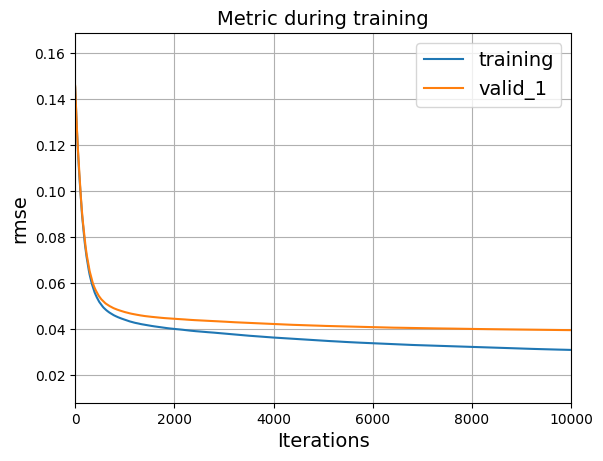

In [110]:
print('画出训练结果...')
ax = lgb.plot_metric(evals_result, metric='rmse')  # metric的值与之前的params里面的值对应
plt.show()

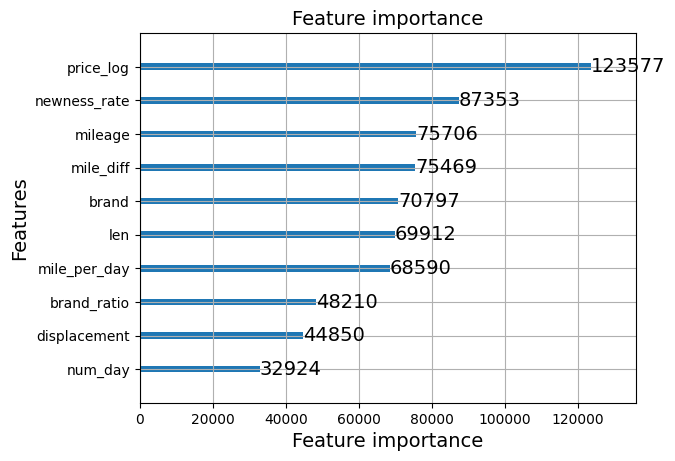

In [111]:
lgb.plot_importance(best_gbm_model, max_num_features=10)  # max_features表示最多展示出前10个重要性特征，可以自行设置
plt.show()

In [112]:
# 模型保存
best_gbm_model.save_model('fuel_model.txt')